# Statistical foundations of machine learning - Richter's Predictor : Modeling Earthquake Damage
https://universitelibrebruxelles.sharepoint.com/:v:/s/GRP_machinelearning187/ETicBVepH8JJg9nOCFcW53UBPZ0ASI8b1KOzJ0QoCVgdTQ?e=M6Kif6

## Dependencies

This notebook was written using R version 4.1.2, with the packages listed below. 

In [1]:
rm(list = ls()) # Wipe memory
set.seed(2023)

# Plotting packages
library(ggplot2) # GGplot2
library(ggfortify) # GGplot2 object interpreter
options(repr.plot.width = 15, repr.plot.height =15) # Sets the size of the ggplots

# Data processing packages
library(glmnet) # Lasso
library(dummy) # dummy generation

# Model packages
library(rpart) # Decision Trees
library(rpart.plot) # Decision Trees plotting
library(randomForest) # Random Forest
library(gbm) # Gradient Boosting Model
library(lazy) # KNN
library(class)

dummy 0.1.3

dummyNews()

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Loaded gbm 2.1.8.1

Loading required package: Matrix

Warning message:
“package ‘Matrix’ was built under R version 4.3.0”
Loaded glmnet 4.1-7



In [2]:
ConfusionMatrix <- function(y_pred, y_true) {
  Confusion_Mat <- table(y_true, y_pred)
  return(Confusion_Mat)
}
 
ConfusionDF <- function(y_pred, y_true) {
  Confusion_DF <- transform(as.data.frame(ConfusionMatrix(y_pred, y_true)),
                            y_true = as.character(y_true),
                            y_pred = as.character(y_pred),
                            Freq = as.integer(Freq))
  return(Confusion_DF)
}
 
Precision_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
 
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
 
  TP <- c()
  FP <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]

    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
   
    tmp <- Confusion_DF[which(Confusion_DF$y_true!=positive & Confusion_DF$y_pred==positive), "Freq"]
    FP[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Precision_micro <- sum(TP) / (sum(TP) + sum(FP))
  return(Precision_micro)
}
 
Recall_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
 
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))

  TP <- c()
  FN <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]

    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
 
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred!=positive), "Freq"]
    FN[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Recall_micro <- sum(TP) / (sum(TP) + sum(FN))
  return(Recall_micro)
}
 
F1_Score_micro <- function(y_true, y_pred, labels = NULL) {
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
  Precision <- Precision_micro(y_true, y_pred, labels)
  Recall <- Recall_micro(y_true, y_pred, labels)
  F1_Score_micro <- 2 * (Precision * Recall) / (Precision + Recall)
  return(F1_Score_micro)
}

## Task I - Data preprocessing, feature engineering, feature selection using PCA and lasso

### Data discussion, preprocessing and feature engineering
In this part we deal with the raw csv files containing the data we will use later on. We do several things here : convert the string type read by R in the csv files to factors in order to consider them at categorical variables. We check if there are any not available (NA) values in the dataset. We generate dummy variables in order to convert every categorical variables of $k$ levels to $k$ new variables. We assess the proportion of each `damage_grade` level in the dataset.

In [3]:
# Read the train_values.csv file, containing the training data for
# the project. We specify stringAsFactors=True, because we want to
# automatically the categorical variables (which are seen as strings)
# in the original file, to factors. 
data = read.csv("train_values.csv", stringsAsFactors=T)

# Read the train_labels.csv file which we will use as our target
# labels in the training process, as well as the test_values.csv file
# from which we will build the predictions we will submit
trainLabels = read.csv("train_labels.csv")
testValues = read.csv("test_values.csv", stringsAsFactors=T)

The code below shows that there aren't any not available (NA) values in the dataset.

In [4]:
# is.na(data) returns a matrix with TRUE/FALSE values
# for each component of the data frame data. We then call
# colSums in order to get the amount of NA element per feature.
# Finally, we sum the colsums obtained to get the number of NA
# element in the whole dataset
sum(colSums((is.na(data))))

[1] 0

The code below details the number of categorical features present in the data set with their respective levels. Since we are going to generate dummy variables, we can see that from that code that we will add roughly 38 features (total amount of levels accross all categorical features) and remove 8 features (total amount of categorical features), so we can expect a net addition of 30 features to this dataset.

In [5]:
# categories is a function of the package dummy
# that displays each categorical feature and its 
# factor levels.
print(categories(data))

$land_surface_condition
[1] "n" "o" "t"

$foundation_type
[1] "h" "i" "r" "u" "w"

$roof_type
[1] "n" "q" "x"

$ground_floor_type
[1] "f" "m" "v" "x" "z"

$other_floor_type
[1] "j" "q" "s" "x"

$position
[1] "j" "o" "s" "t"

$plan_configuration
 [1] "a" "c" "d" "f" "m" "n" "o" "q" "s" "u"

$legal_ownership_status
[1] "a" "r" "v" "w"



The code below generates `dataDums`, a data frame which contains all the levels of each individual categorical feature, as features. The components are binary, 0 or 1.
Then we define `varsToRemove`, which is a vector contaning the column ids of all 8 categorical features present in the dataset.
Finally, we define `dataPP`, the dataframe composed of the initial data frame `data` without the 8 categorical features we fetched in the previous step, joint with the `dataDums` data frame and the training label `damage_grade` from `trainLabels`. We keep `damage_grade` as an int type, because we need it in order to apply a PCA.

In [6]:
# Generate the dataDums data frame with the dummy 
# function from dummy package. Here the option 
# int=TRUE is used to create integer types dummies, 
# instead of the default factor ones
dataDums = dummy(data, int=TRUE)

# Create the vector containing the column ids
# of all categorical fatures in data. The function
# sapply is used to fetch all column names 
# corresponding to the class factor in data[1,]. Here
# we consider just the first line because the type of 
# a variable is the same for all entries in a dataset.
# Finally, we apply the which function on that vector
# in order to get the numerical ids of each column
varsToRemove = which(sapply(data[1,],class)=="factor")

# Finally we create the dataPP (preprocessed) data frame
# which is a merging between the data dataframe without
# the 8 fetched categorical features ids, the dataframe 
# containing the dummy variables dataDums and the training
# labels damage_grade, that will be our target variable
damage_grade = trainLabels$damage_grade
dataPP = cbind(data[,-varsToRemove], dataDums, damage_grade)

# We set the rownames of the dataPP data frame to be the 
# specified building_id, then we drop the building_id
# column from the data frame
rownames(dataPP) = dataPP$building_id
dataPP = dataPP[,-1]

head(dataDums)
print(varsToRemove)
head(dataPP)

,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,⋯,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,1,0,0,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,1,0
5,0,0,1,0,0,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,1,0
6,0,0,1,0,0,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,1,0


land_surface_condition        foundation_type              roof_type 
                     9                     10                     11 
     ground_floor_type       other_floor_type               position 
                    12                     13                     14 
    plan_configuration legal_ownership_status 
                    15                     27 


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,⋯,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,damage_grade
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
802906,6,487,12198,2,30,6,5,1,1,0,⋯,0,0,0,0,0,0,0,1,0,3
28830,8,900,2812,2,10,8,7,0,1,0,⋯,0,0,0,0,0,0,0,1,0,2
94947,21,363,8973,2,10,5,5,0,1,0,⋯,0,0,0,0,0,0,0,1,0,3
590882,22,418,10694,2,10,6,5,0,1,0,⋯,0,0,0,0,0,0,0,1,0,2
201944,11,131,1488,3,30,8,9,1,0,0,⋯,0,0,0,0,0,0,0,1,0,3
333020,8,558,6089,2,10,9,5,0,1,0,⋯,0,0,0,0,0,0,0,1,0,2


We now tackle the balancedness of the data. Since the target is `damage_grade`, let's see in what proportion each level is achieved in this data. The code below computes the percentage of each `damage_grade` level in the dataset, and plots the counts in a barplot. As we can see, this `damage_grade` target is not distributed evenly between its different levels. In fact, levels 2 and 3 are occuring far more often that the level 1 (about 90% of the set fits either in level 2 or 3). This dataset is quite unbalanced.

Percentages of the dataset corresponding to each damage_grade level 
 damage_grade=1:  9.64079186188848 
 damage_grade=2:  56.8911861428007 
 damage_grade=3:  33.4680219953108

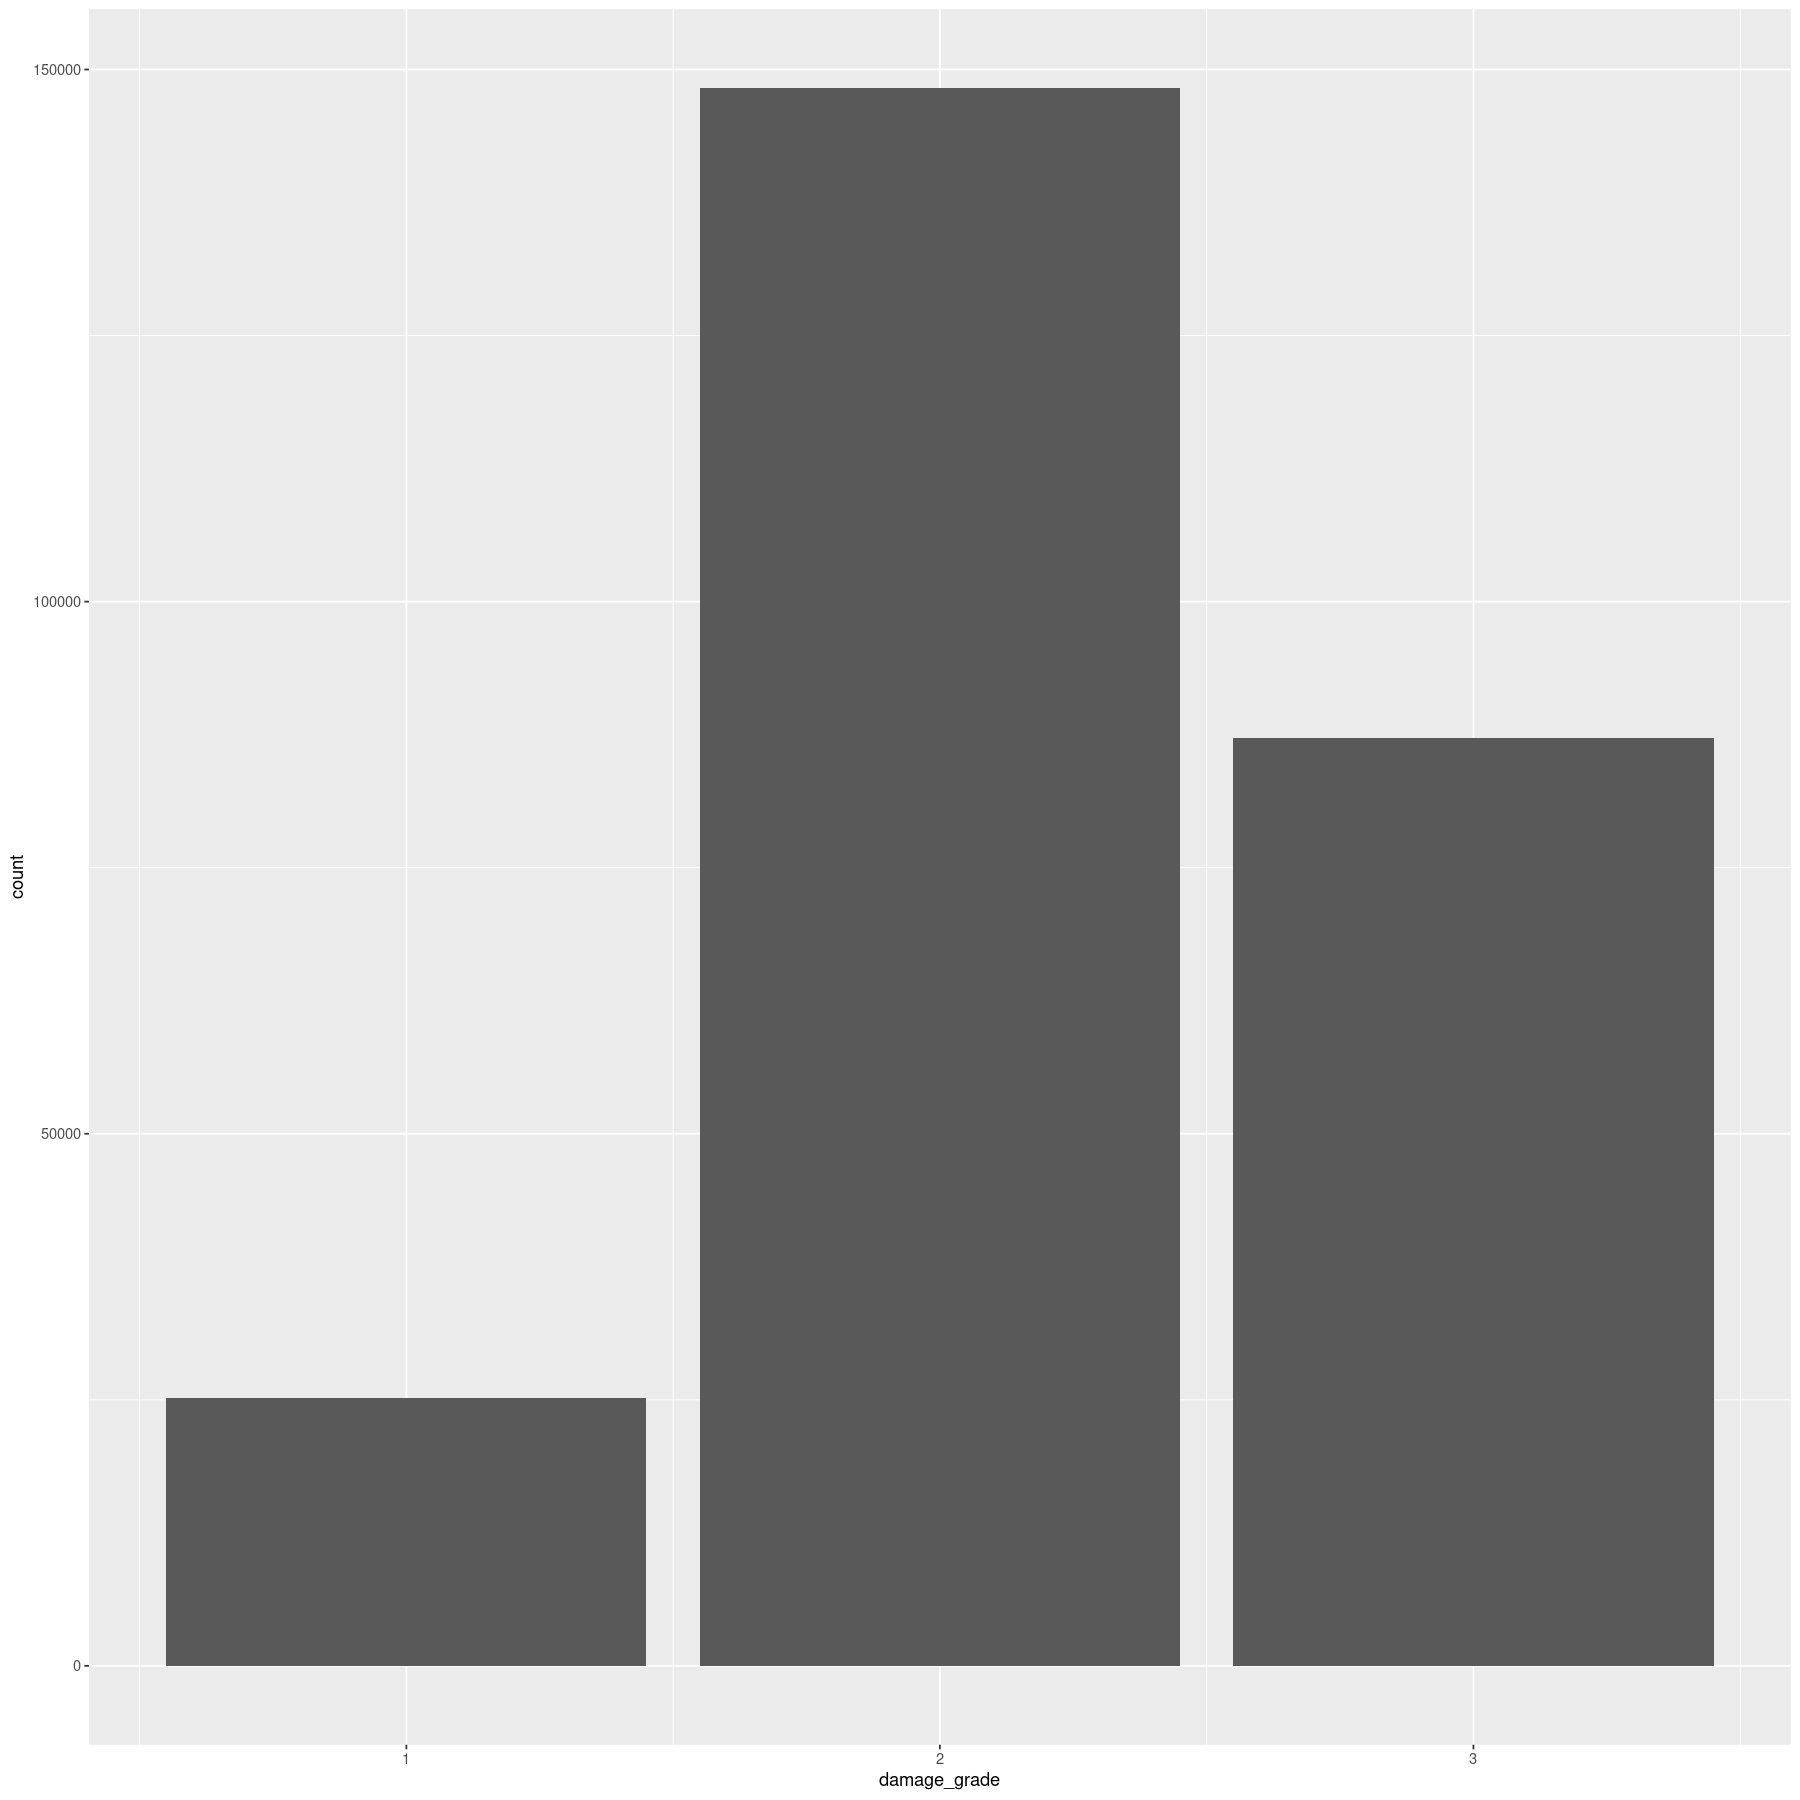

In [7]:
# Call ggplot on the dataPP dataframe specifying
# the x axis to be the damage_grade levels, and
# add the count bars to the plot
ggplot(dataPP, aes(x= damage_grade)) + geom_bar()

# Count the number of total entries in the data frame
# and compute the proportion of each damage_grade level
# by counting the number of entries in each component of
# the damage_grade level based partition of dataPP
numberOfEntries = nrow(dataPP)
cat(paste0("Percentages of the dataset corresponding to each damage_grade level \n"))
cat(paste0(" damage_grade=1:  ", nrow(subset(dataPP, damage_grade==1))/ numberOfEntries *100),"\n", 
    "damage_grade=2: ", paste0(nrow(subset(dataPP, damage_grade==2))/ numberOfEntries *100), "\n", 
    "damage_grade=3: ", paste0(nrow(subset(dataPP, damage_grade==3))/ numberOfEntries *100))

### Feature selection using PCA and lasso
In this part we discuss the feature selection process using two different approaches, the Principal Component Analysis and the Lasso. Let us first start with the PCA approach.

The cells below contain the code for the PCA computation, the plotting of the two first components of the PCA, a barplot of the relative variance explained per axis. 

As we can see on the plot, the amount of features makes it really hard to visually determine the contribution of each feature to the principal components. If we select the first 50 axes, we will have explained 94% of the variance in this dataset. Since the variance explained by each axis is so small (9% in the first case, 5% in the second case etc...), it becomes hard to do any feature selection based on the PCA results. 

Indeed, if we for instance think that we could pick for each axis the features that have the biggest loading, we might end up with almost as many features as we started with (because there is no guarantee that a feature that contributes a lot to a given axis contributes much to other axes), therefore we decided to keep every feature in the dataset. 

Having fewer principal components that explain most of the variance in the dataset would make this task easier. In short, we assessed how the PCA applied to our dataset. Because of the amount of axes it computed and the weak variance explained by each of them, picking features based on the PCA in this case did not really work out. 

In [9]:
# Generate a pca object using the prcomp function
# we discard the first column (building_id) as it
# is an identifier more than an actual measure. 
# We specify scale=TRUE so that all variables have
# a unit variance. 
pca = prcomp(dataPP, scale=TRUE)

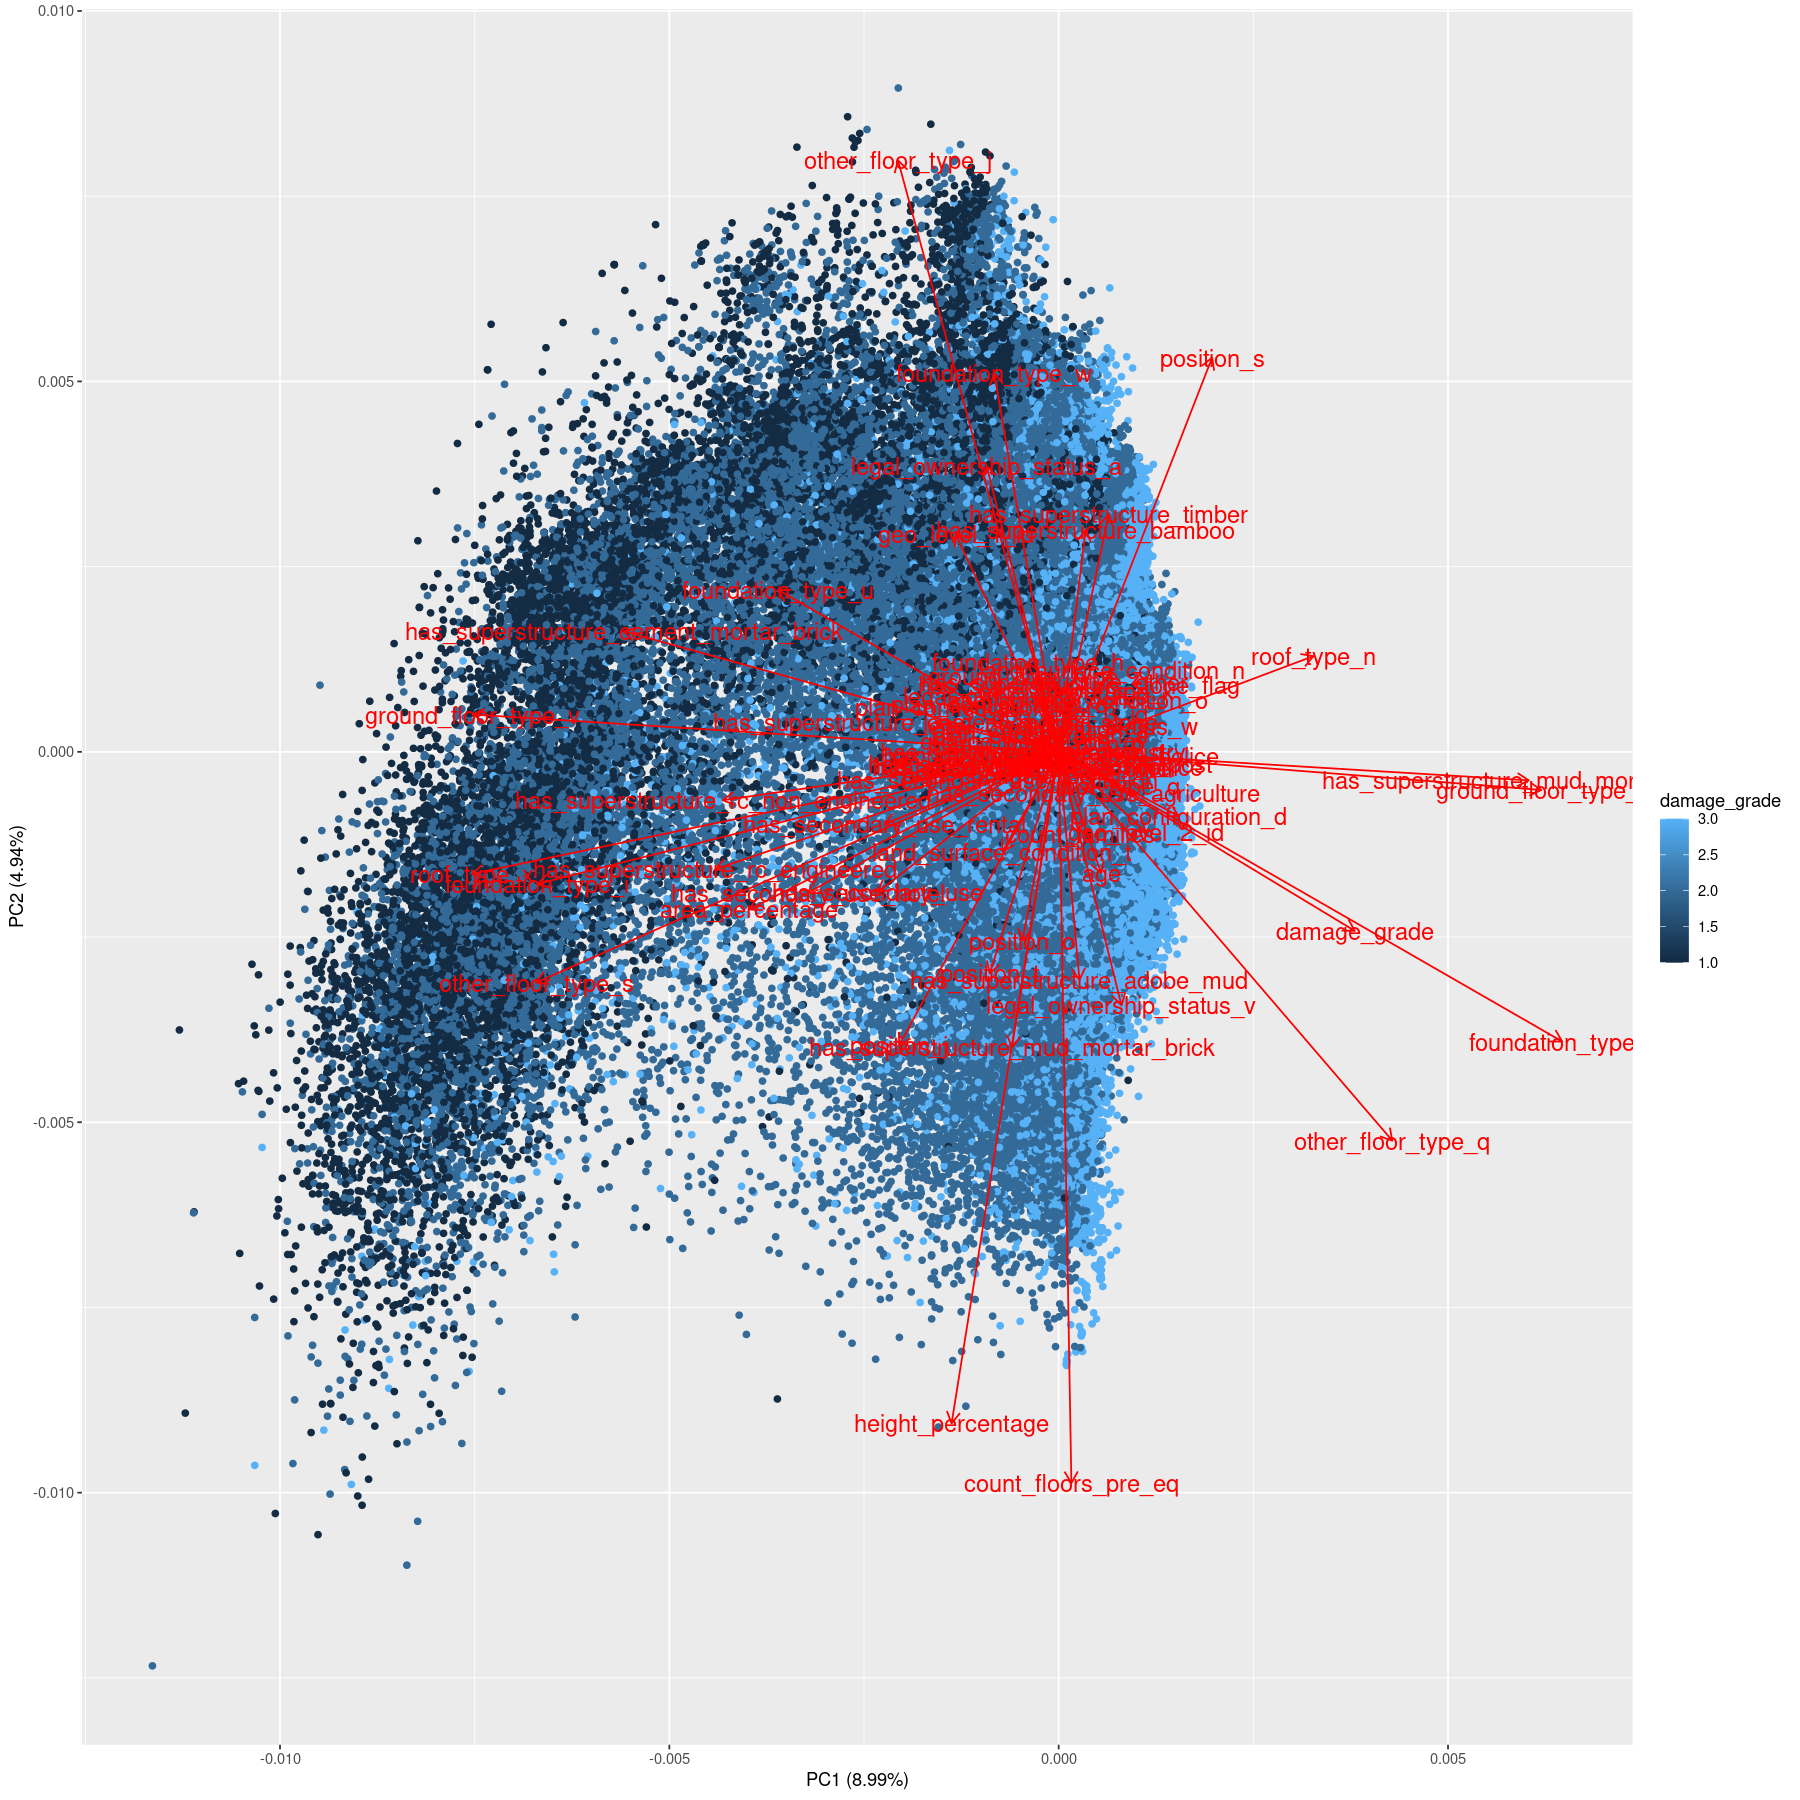

In [10]:
# Calls autoplot to plot the pca object we specify
# on x the first axis and on y the second axis we 
# specify the data, as well as the colour of the dots
# that will be based on the damage_grade value. We specify
# loadings = True to display each feature's contribution to 
# each axis, display the label of each loading, specify a 
# label size 
autoplot(pca, x = 1, y = 2, 
        data = dataPP, colour = 'damage_grade', 
        loadings = TRUE, loadings.label = TRUE, loadings.label.size = 5)

Variance explained by the first 50 axes: 94.3014052138276

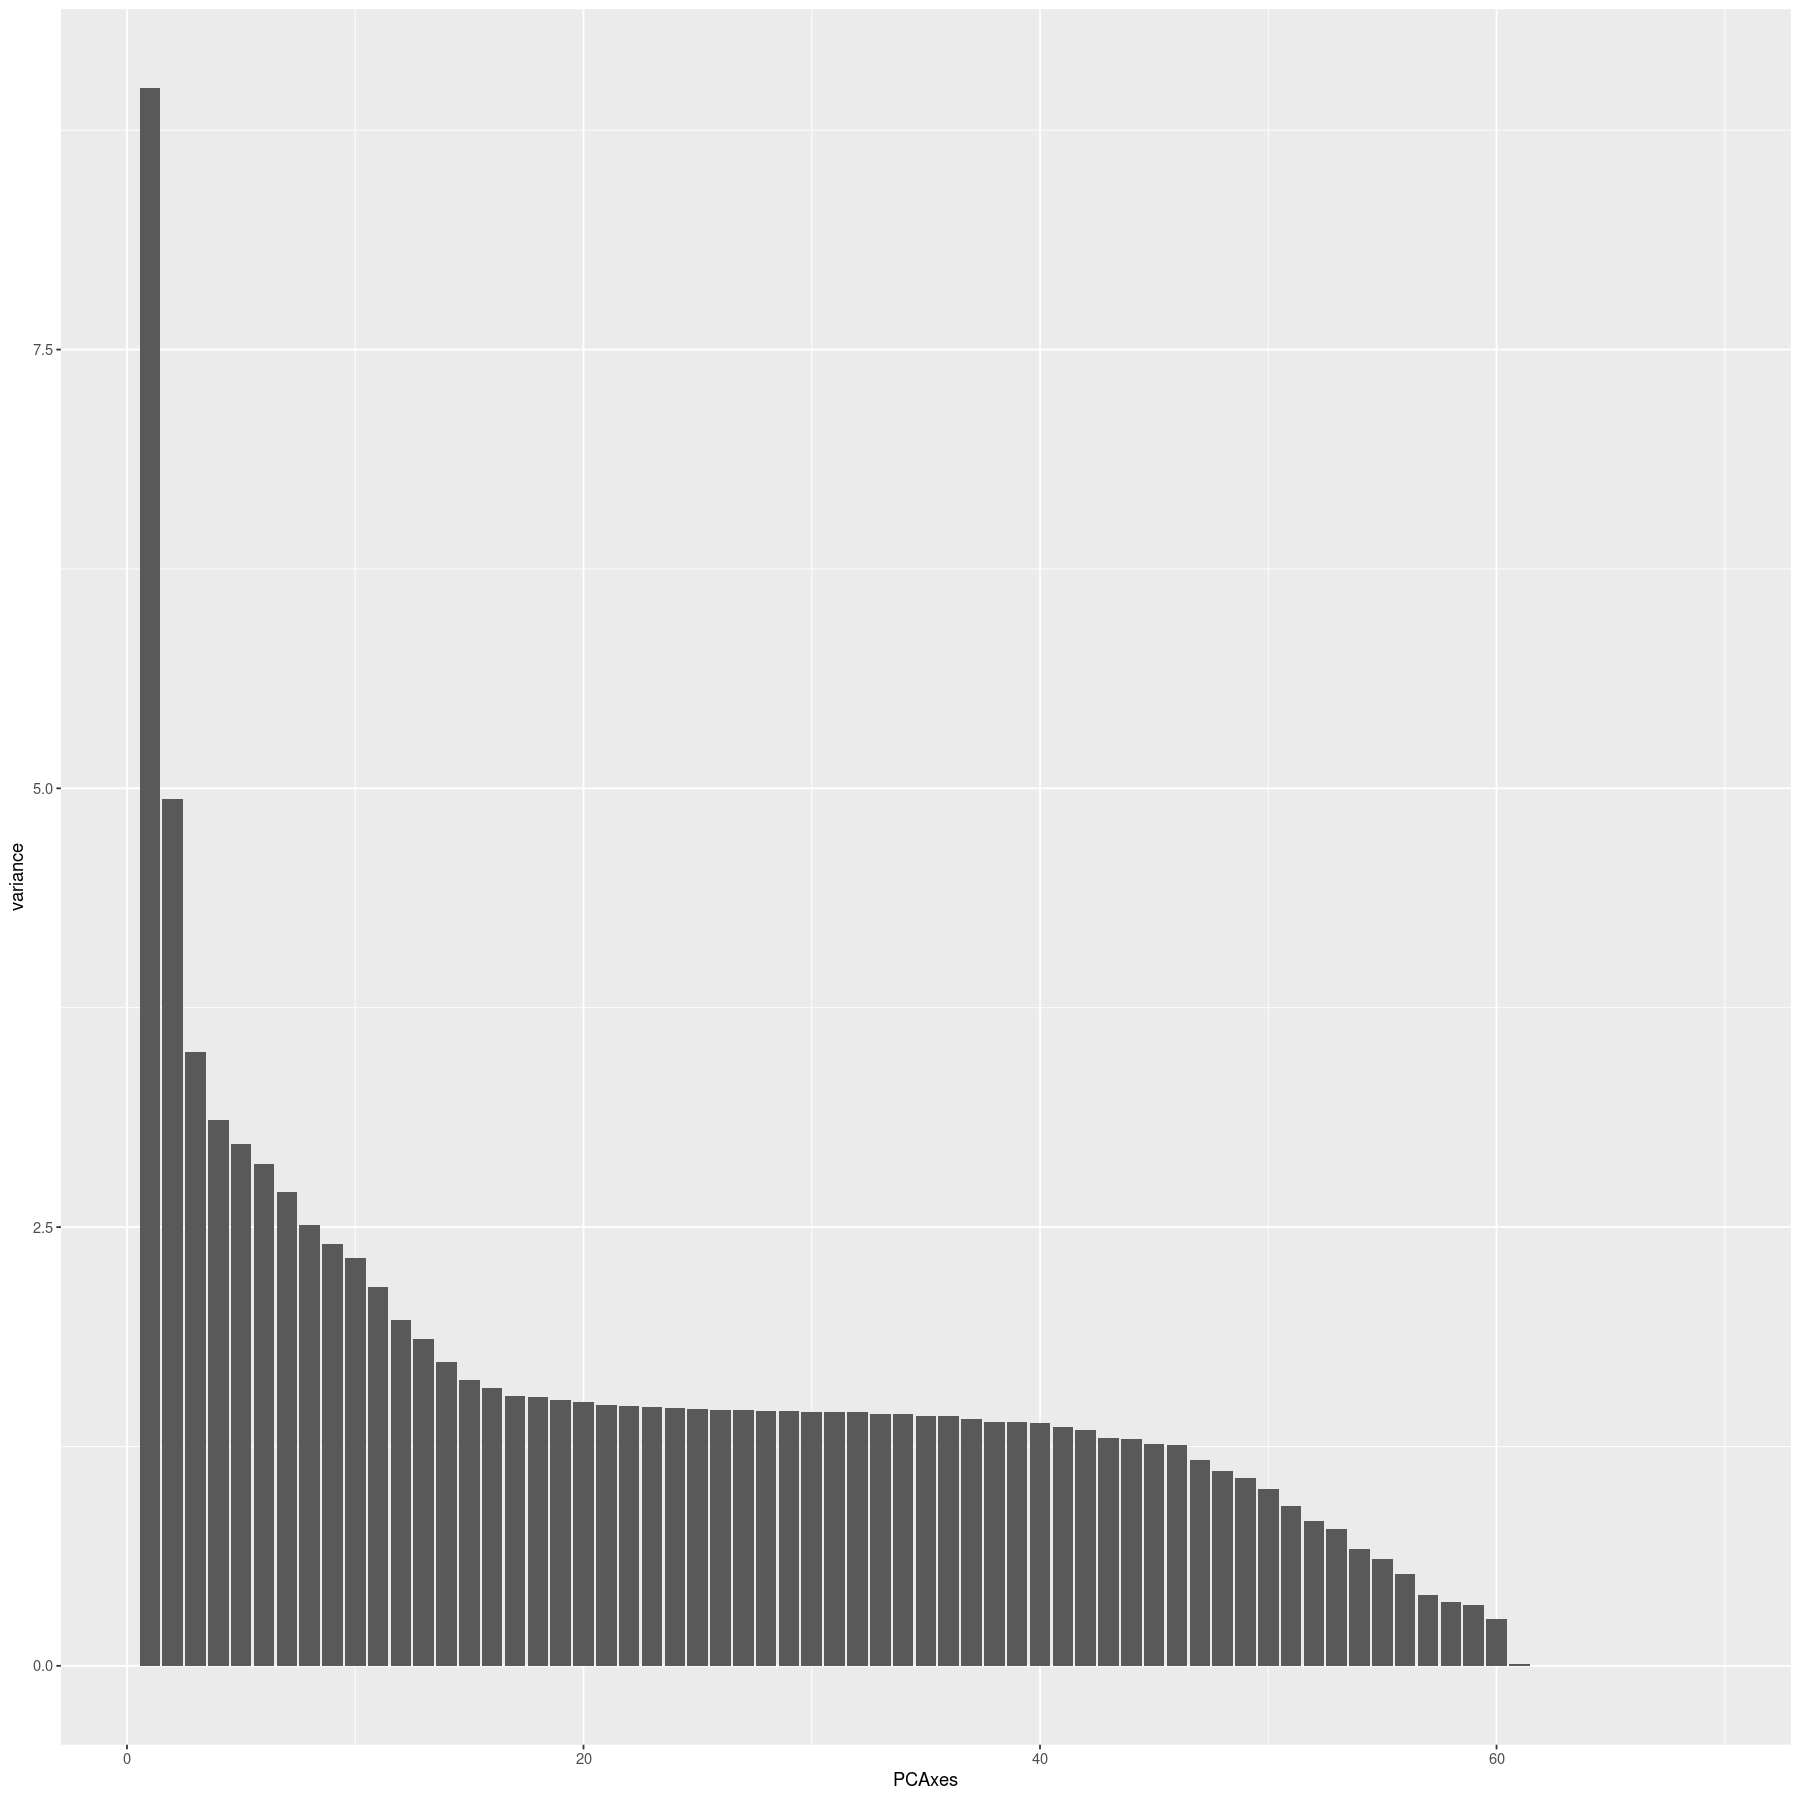

In [11]:
# Compute a vector variance that contains
# the dataset variance explained by each 
# axis', in percentage
variance = (pca$sdev^2 / sum(pca$sdev^2))*100

# Print the sum (total variance explained)
# of the variance vector for the first 50 axes
cat(paste0("Variance explained by the first 50 axes: ", sum(variance[1:50])))

# For the plot, first define a dataframe d that
# contains the axis number and the variance it 
# explains. Finally call ggplot and specify columns
# to obtain a barplot
d = data.frame(PCAxes=c(1:69), variance) 
ggplot(d, aes(PCAxes, variance)) + geom_col() 

We can now convert our `damage_grade` response to a factor in order to train our models for lasso and classification.

In [8]:
dataPP$damage_grade <- as.factor(dataPP$damage_grade) #converts damage grade into a factor variable 

# predictors <- dataPP[,-ncol(dataPP)] #removes last column of dataPP, which is the target variable 
# target <- dataPP[, ncol(dataPP)] #makes last column of dataPP the target variable 
# predictors_matrix <- as.matrix(predictors) #transforms the predictors into a matrix because the cv.glmnet() 
# #needs a matrix or a data frame

# fit_lasso <- cv.glmnet(x=predictors_matrix, y=target, family = "multinomial", type.measure = "class")

In [ ]:
# plot(fit_lasso)

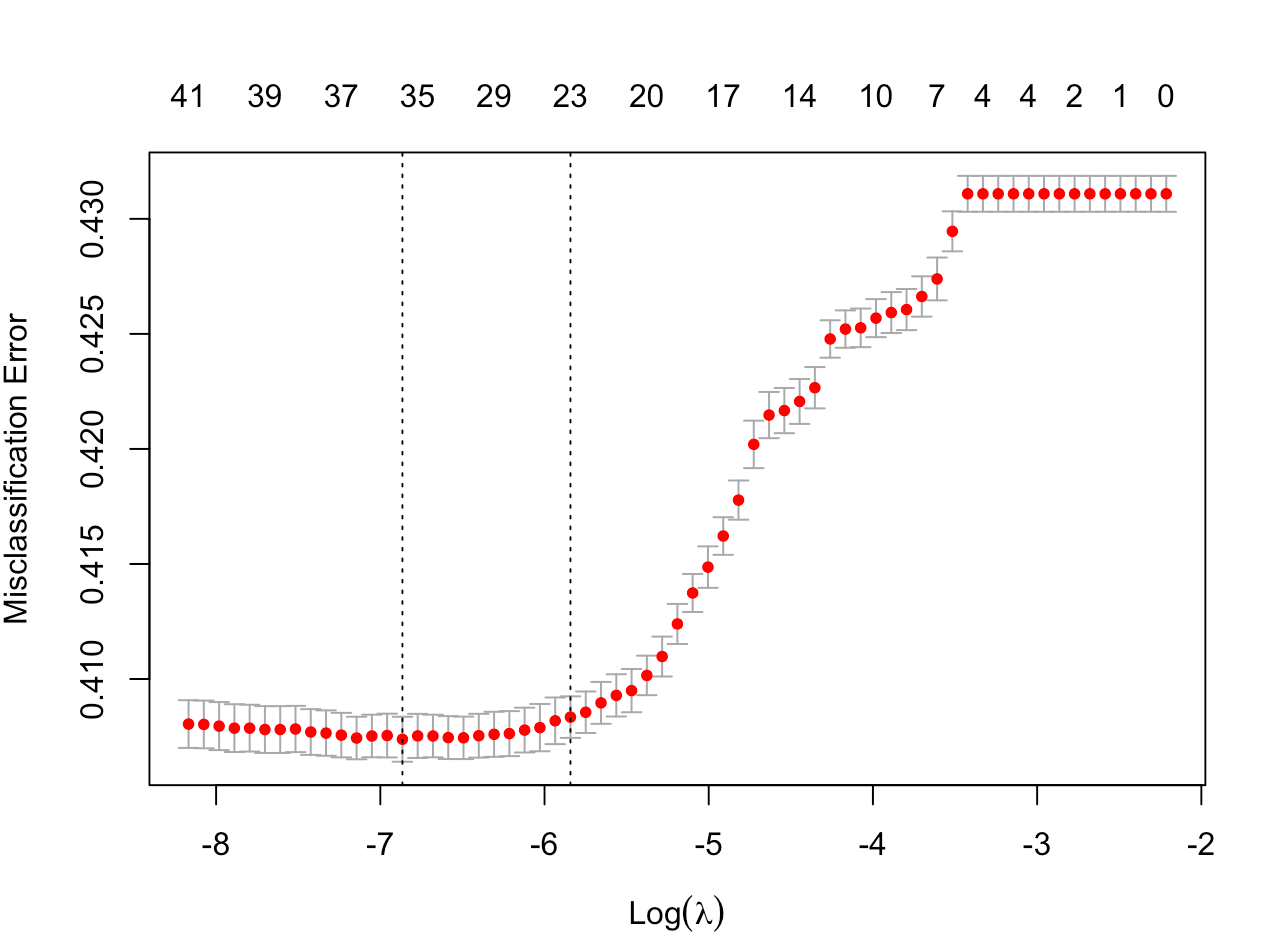

In [ ]:
# opti_lambda <- fit_lasso$lambda.min #this will give us the optimal value for the penalty parameter 

# coefficients_lasso <- coef(fit_lasso, s = opti_lambda) 
# #This extracts the coefficients of the predictors associated with the optimal value of lambda
# #this shows us the values of coefficients, and we see that some are equal to zero,
# #meaning that those variables are not relevant for our classification problem 
# #and that we sould thus remove them 

# lasso_selection <- lapply(coefficients_lasso, function(x) which(x != 0))
# print(lasso_selection)
# #This is a function that selects all the features that are relevant for our classification problem. Those are all 
# #all the features for which the coefficient is different from zero. 

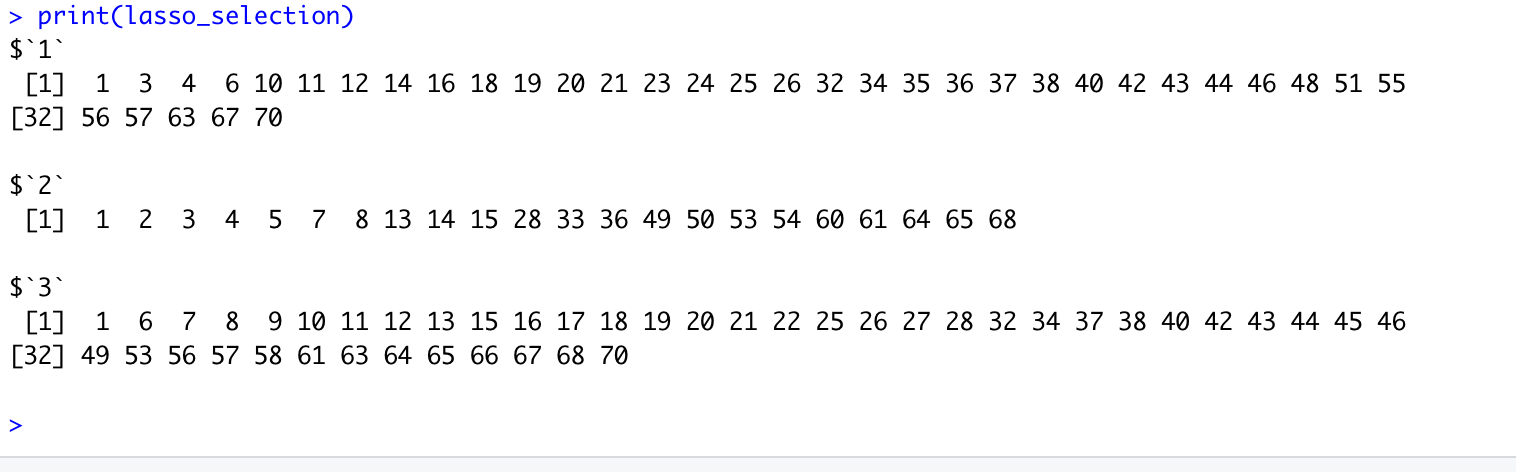

We see in the output above that almost all variables are considered to be relevant by the LASSO estimator for our classification problem. There are a few features for which the coefficient are equal to zero, meaning that those features will have no importance in the classification. However, the number of irrelevant features is pretty small. On the other hand, the results of the PCA confirm that there are a few variables that could be considered irrelevant for our classification problem. Combining the results of our PCA and the LASSO, we chose to keep all features in our model.

## Task 2 : Decision Tree, Random Forests and K-Nearest neighbors models

### Decision Tree

#### Model selection

The main parameter in decision trees is the complexity parameter (cp). Here we discuss how we picked the optimal value for our model. The complexity parameter is key in the building of a decision tree, because it influences the depth of the tree we're building, and, too deep of tree can result in overfitting when applying to new data.

In order to find the right `cp` value, we train a model using the `cp=0` value, in order to assess for which value of `cp` we have the lowest xerror.

In [20]:
# Train a decision tree classifier using rpart
# on the whole dataset, specifying the response
# variable to be damage_grade. This time we 
# specify a cp=0.005, as explained above
decisionTreeModel = rpart(damage_grade ~., data=dataPP, cp=0, method="class")

According to the output of the cell below, the best `cp` value for our model is `2.37370410591468e-05`, which corresponds to a tree with 2449 splits.

In [21]:
# We seek the row id for which the cptable has the lowest value in the
# 4th column, that is the xerror column, and then we print the CP value
# associated to it. This value is the one we will take to make the following
# predictions for that model
cp = as.numeric(decisionTreeModel$cptable[which.min(decisionTreeModel$cptable[,4]),][1])
cp
decisionTreeModel$cptable[which.min(decisionTreeModel$cptable[,4]),][]

[1] 2.373704e-05

CP       nsplit    rel error       xerror         xstd 
2.373704e-05 2.449000e+03 5.520108e-01 6.350608e-01 2.026164e-03

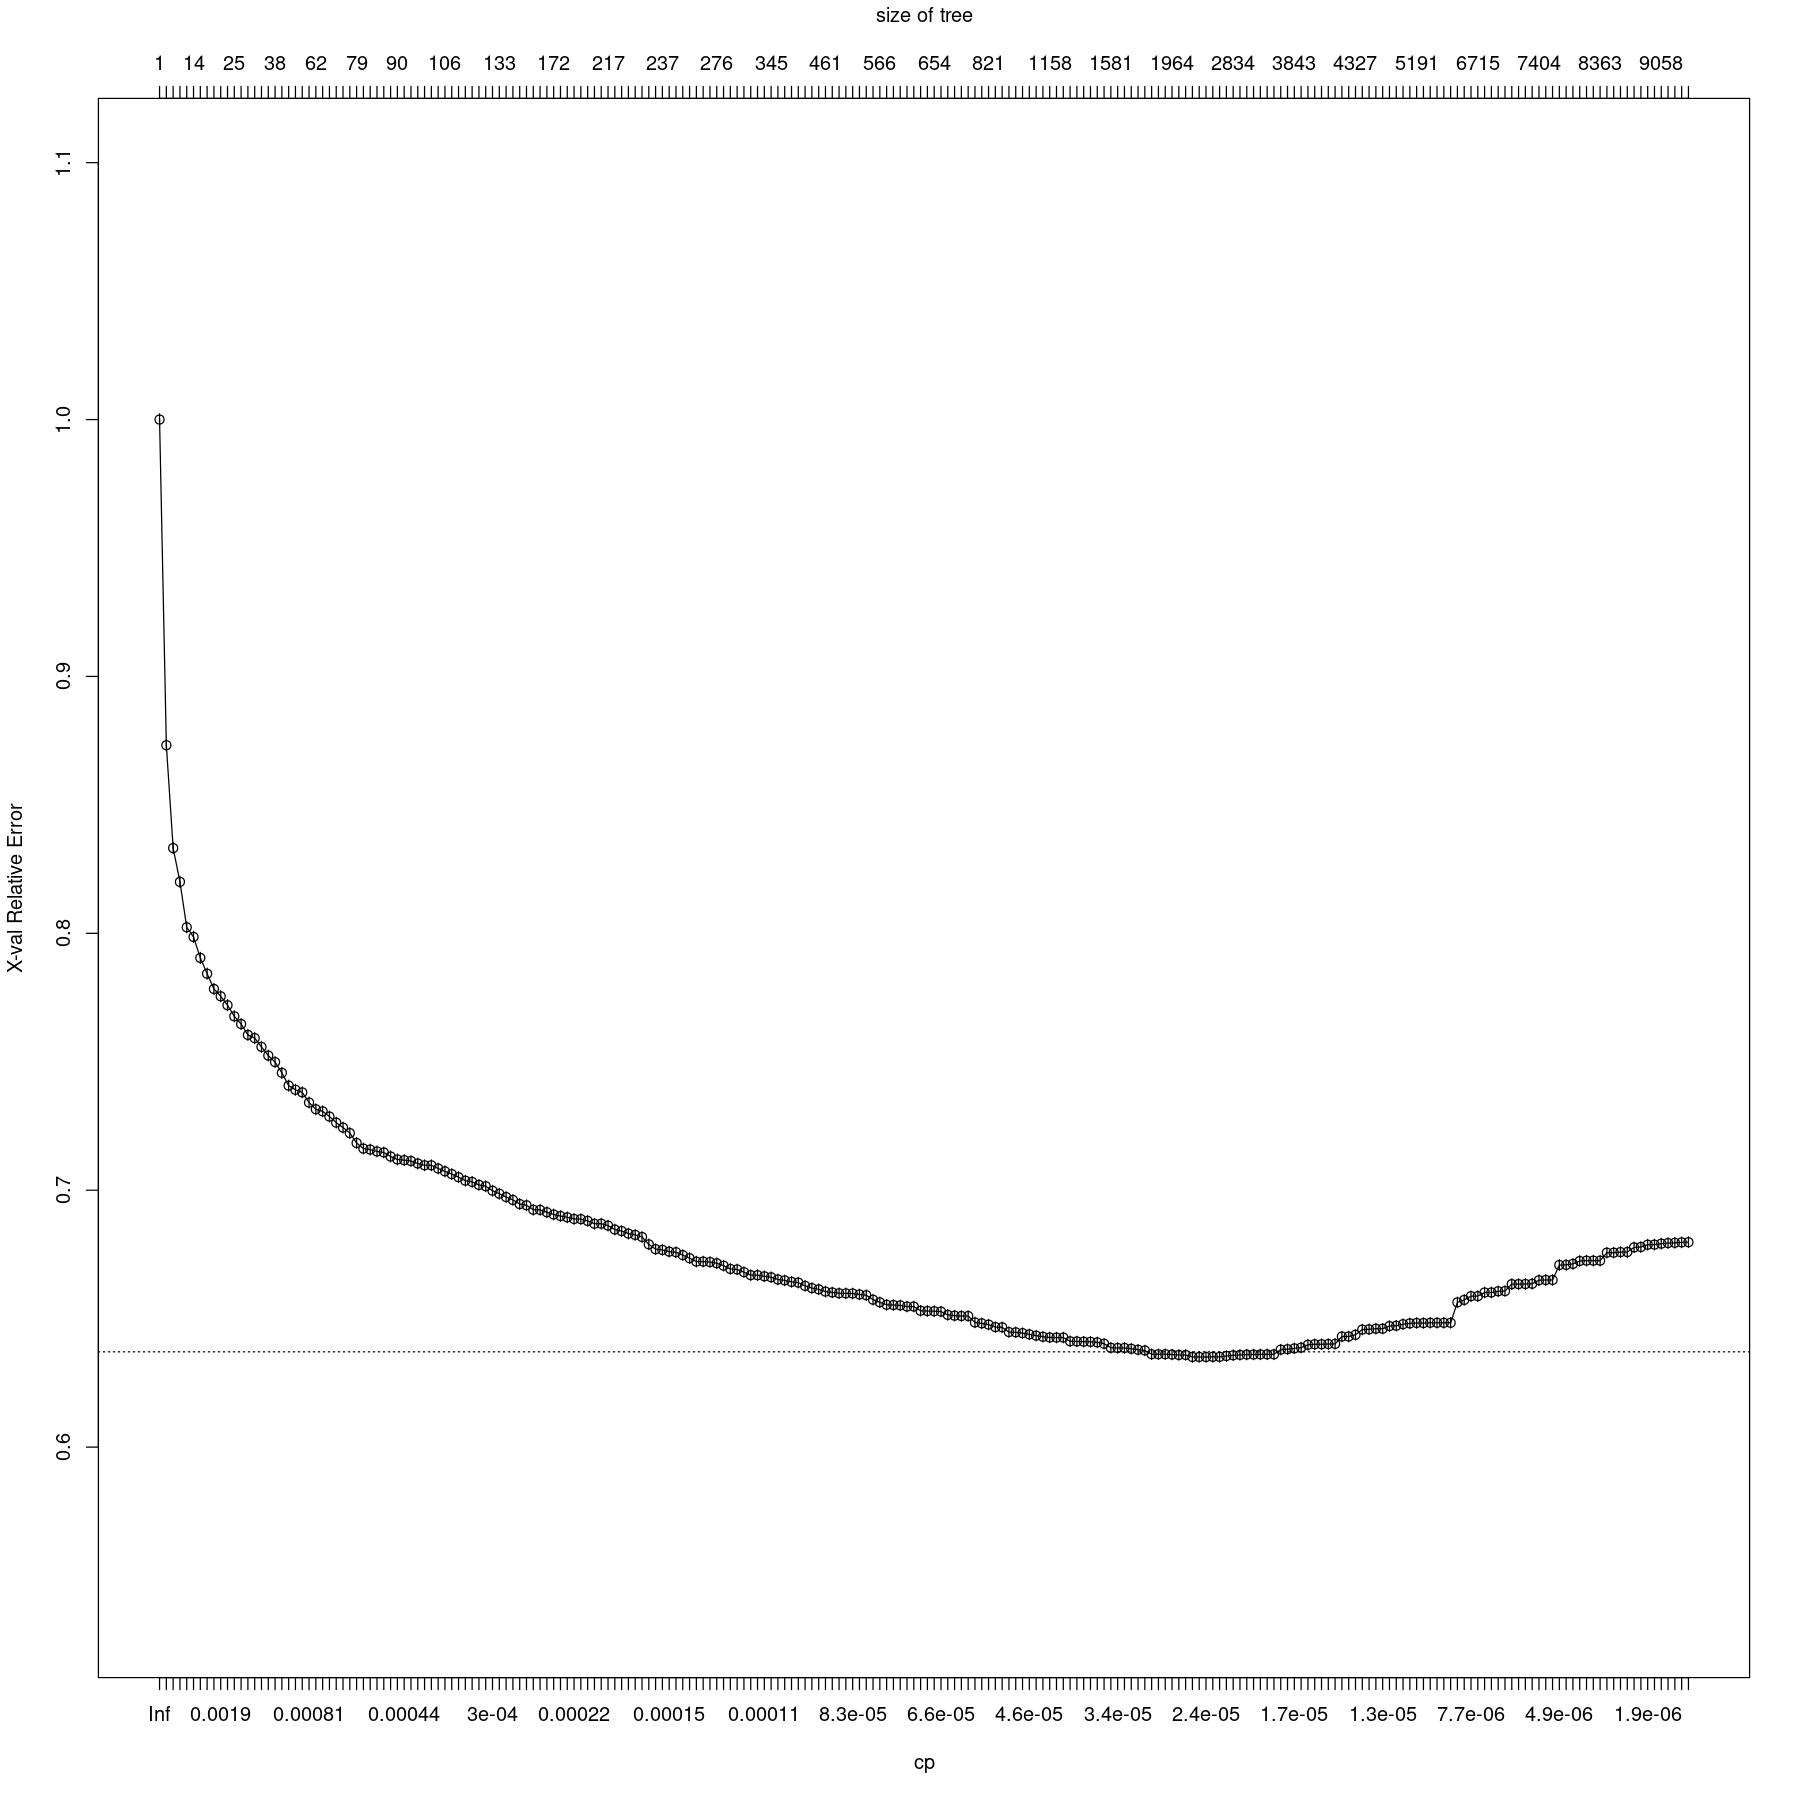

In [15]:
# I tried to find a way to add an abline to
# this graph in order to show where the 2.3e-05 value
# stand on the x-axis, but didn't manage to. The zone 
# it stands in is the local minima of the plateau
plotcp(decisionTreeModel)

#### Quality assessment of the model through k-fold cross validation
In this part we want to assess how good and reliable a decision tree model with the complexity parameter found in the last selection would be at predicting the classes `damage_grade` in our dataset. 

In order to do that, we use a k-fold cross validation. Here we ran the cross validation with 10 folds, which means we train 10 models on 10 different combinations of training set/validation sets, by splitting our initial data set in 10, taking one fold for validation and 9 others for training, and repeating this process 10 times by iteratively increasing the validation fold index.

From this algorithm we can compute the averaged value of the micro-F1 metric obtained over each model's prediction on their respective validation set.  This gives us an idea of how efficiently our model is able to expand to unseen data, as well as assessing its sensitivity to the training data. 

In the cell below, we obtained a mean $F1 =  0.726117877411623$ with a standard deviation of $0.00241665615093842$. The mean F1 value is quite decent, and, according to the model selection, it is unlikely that we can perform better in the model conception (though, we could arguably do better with proper feature selection). The standard deviation is quite small, which indicates that the model isn't too sensitive to the train data, or that indeed the training data observations were randomized good enough as to not induce too much bias in the training of our different models.

In [20]:
# Define the function kFDecisionTree which is used
# to perform kfold cross validations of a decision
# tree model over the data set.
kFDecisionTree = function(k, data){

    # First we initialize the vector that will contain
    # the F1 measures for each individual classifier
    f1 = c()
    
    # We re-define the random seed, because here we 
    # call sample that performs a random picking of 
    # our entries
    set.seed(2023)
    shuffled = sample(1:nrow(data))
    max = ceiling(nrow(data)/k)

    # We split into k fold 
    splits = split(shuffled, ceiling(seq_along(shuffled)/max))

    # For each training/validation set combination 
    for (i in 1:k){

        # That the i-th fold as being the test data-set
        test_data = data[splits[[i]],]
        
        # Take the remaining groups as being the training data-set
        train_data = data[-splits[[i]],]

        # Train a model using the training set, 
        # specifying cp=cp, the minimum cp we determined
        # in the model selection step
        model = rpart(damage_grade ~ ., method="class",data=train_data, cp=cp)
        
        # Define the data frame predictions by 
        # predicting the first 68 columns of our dataset
        # (the last one is to be excluded, as it is the
        # target)
        predictions = predict(model,test_data[,-69])

        # Since we now have a data frame with 3 columns, each
        # of which stands for a level of the target, we must,
        # for each entry of the dataframe, take the maximum value
        # of that line and find the column name it corresponds to
        # that is, for each entry, take the level that has the biggest
        # probability assigned to it.
        predictions = colnames(predictions)[apply(predictions,1,which.max)] 

        # Compute the F1_Score_micro between the prediction and 
        # the (true) value in the testing dataset, and add it to
        # the vector of F1 values computed throughout the loop
        f = F1_Score_micro(test_data$damage_grade, predictions)
        cat(paste0("F1 metric for ", i, "-th validation set : ",f, "\n"))
        f1 = c(f1,f)
        
    }
    
    # Print out the mean F1 metric as well as the standard deviation
    cat(paste0("Mean F1 metric: ", mean(f1), "\n"))
    cat(paste0("Standard deviation F1 metric: ",sd(f1))) 
}

In [21]:
# Crossvalidation for decision tree
kFDecisionTree(10, dataPP)

F1 metric for 1-th validation set : 0.723916964045892
F1 metric for 2-th validation set : 0.72399370707187
F1 metric for 3-th validation set : 0.723264648325083
F1 metric for 4-th validation set : 0.727293657188903
F1 metric for 5-th validation set : 0.726219254825218
F1 metric for 6-th validation set : 0.724876251870611
F1 metric for 7-th validation set : 0.728406431065577
F1 metric for 8-th validation set : 0.725068109435555
F1 metric for 9-th validation set : 0.727025056597982
F1 metric for 10-th validation set : 0.731114693689544
Mean F1 metric: 0.726117877411623
Standard deviation F1 metric: 0.00241665615093842

#### Final model training and features relevancy in this model
Now that we assessed the reliability of our model with respect to the possible combinations of training/validation sets, we can train a model with the whole training set. This allows us to clearly see, which are the most critical features for this model. This will also be a good comparison point with the Task 5 entropy-based feature importance.

In [22]:
# Training a decision tree model using the
# whole dataset, and the cp found in the
# model selection step
decisionTreeModel = rpart(damage_grade ~., data=dataPP, cp= cp, method="class")

The code below fetches the importance of each feature we trained our model on. As we can see, the 5 most important features that contribute to the model are the `geo_level_1_id`, `geo_level_2_id`, `foundation_type_r`, `geo_level_3_id` and the `height_percentage` of a specific building. This will be a good comparison point when we will compute the entropy based feature importance with the decision tree model.

In [23]:
# Convert the variable importance from 
# the model we built to a data frame 
varImpDT = data.frame(decisionTreeModel$variable.importance) 

# Add a feature column corresponding to the features names
varImpDT <- data.frame(feature = row.names(varImpDT), varImpDT) 

# Change the column names of the data frame to "feature" and "importance"
colnames(varImpDT) = c("feature", "importance") 

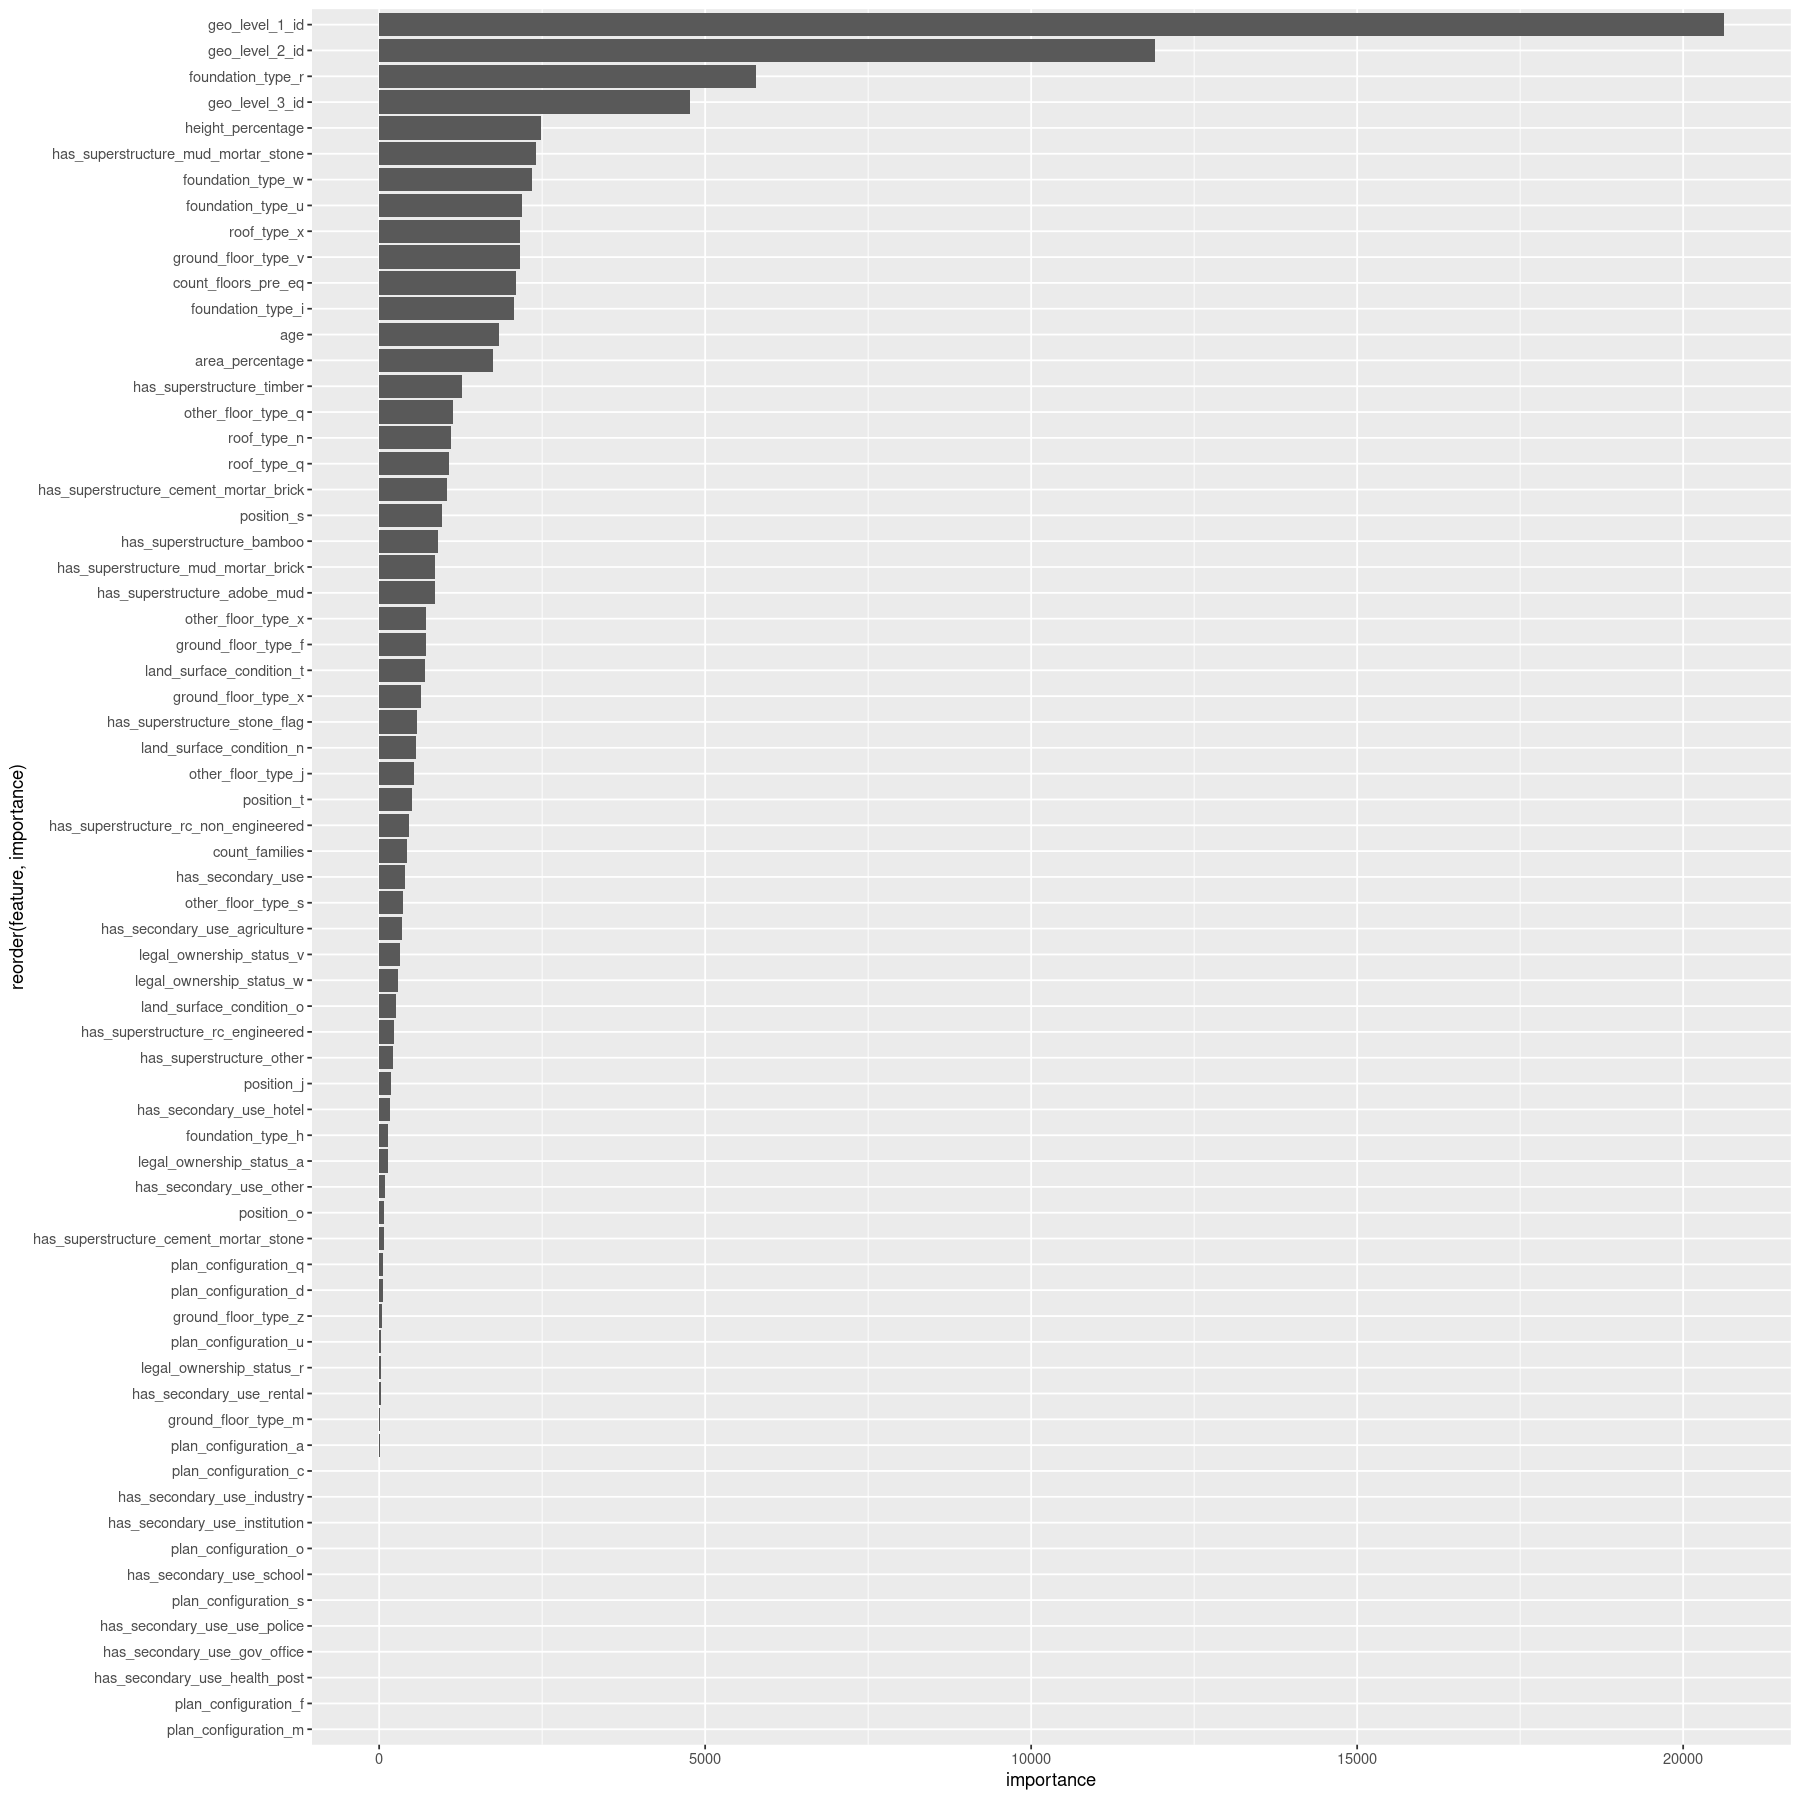

In [24]:
# Call ggplot, specify x to be the importance and y to be a 
# re-ordering of the feature based on their respective importance. 
# We list importance on the x axis to avoid the feature names to overlap
ggplot(varImpDT, aes(x= importance, y=reorder(feature, importance))) + geom_bar(stat='identity')

### Random forest

In [ ]:
# predictor =<-dataPP[,-ncol(dataPP)] 
# target <- dataPP[,ncol(dataPP)]

# trees <- 20 
# # Creates a vector of 0's. The components will be replaced by the accuracy of the 
# # prediction for each number of tree (from 1 to 20) 
# accuracy_vec <- array(0, trees) 
# half_split <- floor(nrow(dataPP)/2)
# target_variable <- ncol(dataPP)
# data_idx <- sample(1:nrow(dataPP))

# train_data <- dataPP[data_idx[1:half_split],]
# test_data <- dataPP[data_idx[(half_split+1):nrow(dataPP)],]

# for (i in 1:trees){
#     model <- randomForest(x=train_data[,-c(target_variable)],
#                         y=as.factor(train_data[,c(target_variable)]),
#                         xtest=test_data[,-c(target_variable)],
#                         ytest=as.factor(test_data[,c(target_variable)]),
#                         ntree=i)
#     accuracy_vec[i] = (model$confusion[1,1]+model$confusion[2,2] + model$confusion[3,3] )/sum(model$confusion)
# }

# plot(accuracy_vec,main = "Number of trees influence",xlab = "Nbr of trees",ylab = "Classification rate")


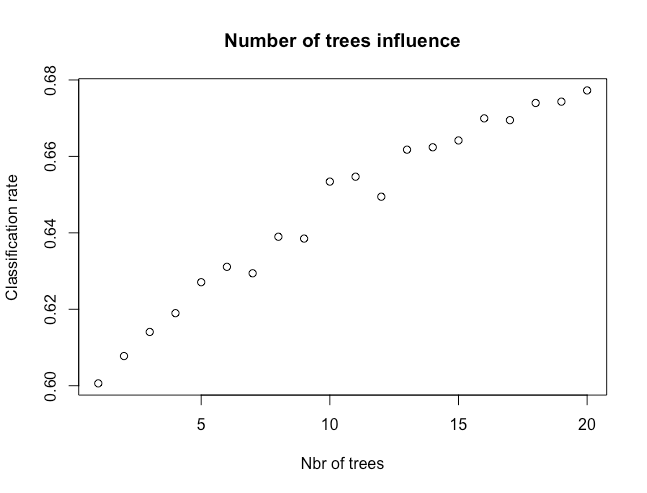

We can see in the graph above that the highest accuracy of the prediction is achieved when we use 20 trees. We will thus use 20 trees in our random forest and, before doing a final model for the classification with random forest, we will do a 10-fold cross-validation. Below is the code we tried running for the k-fold validation of the model. Unfortunately, the error message below appeared and we didnt find a way around it. A work-around we thought about was to use parallelization libraries (that are displayed commented in the code cell below), but this didn't work either.

In [ ]:
# # library(iterators)
# # library(parallel)
# # library(foreach)
# # library(doParallel)
# f1 <- numeric(length = k_fold)
 
# # Define the foreach loop
# foreach(i = 1:k_fold) %dopar% {
#     test_data <- dataPP[splits[[i]], ]
#     train_data <- dataPP[-splits[[i]], ]
   
#          train_data_df <- do.call(rbind, train_data)
#      model <- randomForest(class ~ ., method = "class", data = train_data_df)
     
#      predictions <- predict(model, test_data)
#      predictions <- colnames(predictions)[apply(predictions, 1, which.max)]
           
#      f <- F1_Score_micro(test_data$damage_grade, predictions)
#      cat(paste0("F1 score for sample ", i, ":", f, "\n"))
#      f1[i] <- f
#      }
# mean(f1)

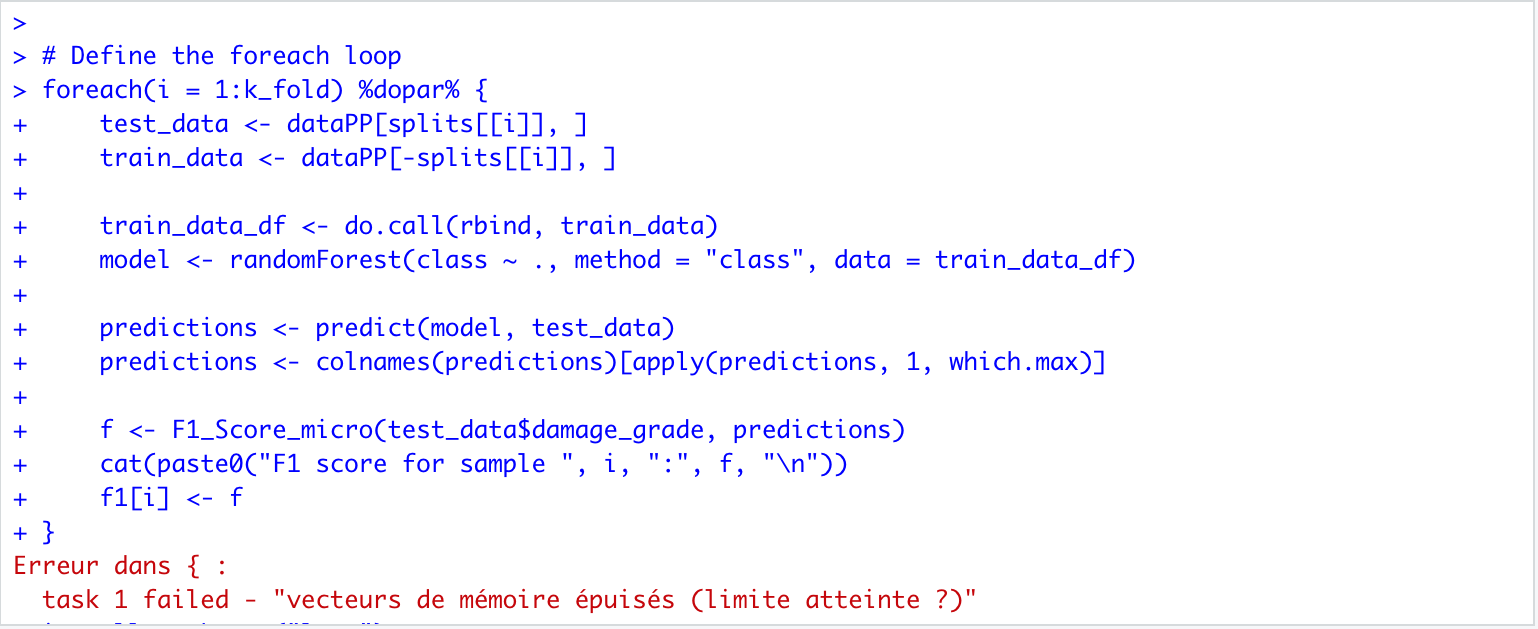

### KNN

We will now use the K-nearest neighbours algorithm to try to make a predictive model for our classification problem. This calculates the euclidean distance between the item we are trying to classify and "k" other neighbourds around it. K is a number of neighbours that needs to be fixed in a way that will be detailed later. The item will be classified the same way the nearest neighbour in terms of Euclidean distance is.

In [ ]:
# neighbours <- 5
# half_split <- floor(nrow(dataPP)/2)
# target_variable <- ncol(dataPP)
# data_idx <- sample(1:nrow(dataPP))
# train_data <- dataPP[data_idx[1:half_split],]
# test_data <- dataPP[data_idx[(half_split+1):nrow(dataPP)],]
# target_subset <- target[1:half_split] #the target and the train and test data sets were not of the same size. 
# #This code is to ensure that they are now of the same size to be able to use the target and the training data sets in 
# # the same function 
# f1 <- numeric(length = k_fold) #

# for(i in 1:neighbours){
#  nn_model <- knn(train_data, test_data, cl = target_subset, k = i)
#  predictions <- nn_model

#  f <- F1_Score_micro(test_data$damage_grade, predictions)
#  cat(paste0("F1 score for sample ", i, ":", f, "\n"))
#  f1[i] <- f
# }

In the code above, we made a loop testing a model with 1 up to 5 neighbours. The number of the sample is the same number as neighbours used in the model for predicting this sample. The output we get gives us the F1 score for each sample, and thus for each number of nearest neighbours used. We will take the number of neighbours with the highest F1 score.

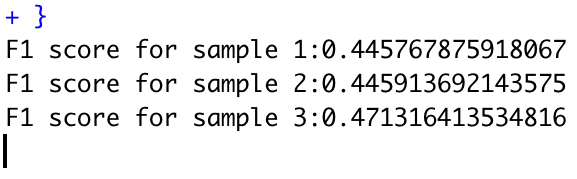

Since these F1 scores seem to be quite low, we will not be using that model for further predictions.

## Task 3 : Gradient Boosting Model

### Model selection and cross-validation
There are a few parameters to consider with Gradient Boosting models from the `gbm` package. The three main are: the number of trees `n.trees`, the `shrinkage` corresponding to the learning rate of the model, and the `interaction.depth` corresponding to the number of splits we perform on each tree. The way gradient boosting models work is that they add together weaks learners that minimize a loss function, by using a gradient descent. Here the weak learners are decision trees. 

Unlike the decision tree before, it seems that parameter tuning in gbm takes a **lot** of time, and very often **crashes the R kernel** for too complex parameters (or when including a cross validation using `cv.folds` argument), which makes the whole process very complicated.

What we did instead is picking some values almost at random (although we reckon it is obviously not the best approach), and assessed the results. On average, the k-fold function below using the parameter couples had a runtime ranging from 40 minutes to more than an hour per run. We did that for 6 couple of parameters (`n.trees`,`interaction.depth`), and assessed them using a 5 folds cross validation (not the one implemented by the algorithm, which seems to crash the kernel). 

From that small set of parameter couples, we noticed that `n.trees=500` and `interaction.depth=3` gives the best fold-averaged F1 score out of all the couples we tried. Although we underline that it is likely that there exists better parameters, we want to mention that we actually tried more outside of the ones displayed below, and optimizing these parameters as such would require a lot of time. We will therefore go with this parameters for the final model training.

Additionally, since we are not using that many trees, the `shrinkage` parameter is set to 0.1, as the convergence of the model relies on the number of trees and the learning rate, having few trees implies needing a bigger time step, and, conversly, if we had more trees we would pick a smaller `shrinkage` value.

In [25]:
# Define the function kFGBM which is used
# to perform kfold cross validations of a gradient boosting
# model, using the specified inter (interaction.depth) and
# ntrees (n.trees) parameters
kFGBM = function(k, data, inter, ntrees){

    # First we initialize the vector that will contain
    # the F1 measures for each individual classifier
    f1 = c()
    
    # We re-define the random seed, because here we 
    # call sample that performs a random picking of 
    # our entries
    set.seed(2023)
    shuffled = sample(1:nrow(data))
    max = ceiling(nrow(data)/k)

    # We split into k fold 
    splits = split(shuffled, ceiling(seq_along(shuffled)/max))

    # For each training/validation set combination 
    for (i in 1:k){

        # That the i-th fold as being the test data-set
        test_data = data[splits[[i]],]
        
        # Take the remaining groups as being the training data-set
        train_data = data[-splits[[i]],]

        # Train a model using the training set, 
        # specifying shrinkage=0.1, interaction depth
        # as per the argument and ntrees too
        model = gbm(damage_grade~., data=train_data, n.trees=ntrees, interaction.depth=inter, shrinkage=0.1)
        
        # Define the data frame predictions by 
        # predicting the first 68 columns of our dataset
        # (the last one is to be excluded, as it is the
        # target)
        predictions = predict(model,test_data[,-69])

        # Since we now have a data frame with 3 columns, each
        # of which stands for a level of the target, we must,
        # for each entry of the dataframe, take the maximum value
        # of that line and find the column name it corresponds to
        # that is, for each entry, take the level that has the biggest
        # probability assigned to it.
        predictions = colnames(predictions)[apply(predictions,1,which.max)] 

        # Compute the F1_Score_micro between the prediction and 
        # the (true) value in the testing dataset, and add it to
        # the vector of F1 values computed throughout the loop
        f = F1_Score_micro(test_data$damage_grade, predictions)
        cat(paste0("F1 metric for ", i, "-th validation set : ",f, "\n"))
        f1 = c(f1,f)
        
    }
}

In [26]:
# Saved the different parameters and F1-means from the various outputs (each output took about an hour to run)
# From this dataframe, it becomes clear that out of the 6 combinations of parameters we tried, the one yielding
# the best mean F1 value is ntrees=500, interaction.depth=3
ntrees = c(500, 500, 200, 200, 150, 150)
it =c(3, 6, 2, 3, 6, 4)
fmeans = c(0.708642754885376, 0.690235317179439, 0.680135580391149, 0.690235317179439, 0.701359594788136, 0.691954407490514)
cbind(ntrees, it, fmeans)

ntrees,it,fmeans
500,3,0.7086428
500,6,0.6902353
200,2,0.6801356
200,3,0.6902353
150,6,0.7013596
150,4,0.6919544


The following 5 cells have been commented because each cell has a runtime ranging from 30 ish minutes to more than an hour each, but they were ran in order to make the dataframe above.

In [ ]:
# kFGBM(5, dataPP, 3, 500)

Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 500 trees...




F1 metric for 1-th validation set : 0.707776136298229
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 500 trees...




F1 metric for 2-th validation set : 0.70618368795687
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 500 trees...




F1 metric for 3-th validation set : 0.707258110934173
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 500 trees...




F1 metric for 4-th validation set : 0.710711613361217
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 500 trees...




F1 metric for 5-th validation set : 0.711284225876394
Mean F1 metric: 0.708642754885376
Standard deviation F1 metric: 0.00223454811961579

In [ ]:
# kFGBM(5, dataPP, 2, 200)

Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 200 trees...




F1 metric for 1-th validation set : 0.679630091517814
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 200 trees...




F1 metric for 2-th validation set : 0.678613226914296
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 200 trees...




F1 metric for 3-th validation set : 0.678037643176455
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 200 trees...




F1 metric for 4-th validation set : 0.68116498148539
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 200 trees...




F1 metric for 5-th validation set : 0.683231958861792
Mean F1 metric: 0.680135580391149
Standard deviation F1 metric: 0.00209890721046906

In [ ]:
# kFGBM(5, dataPP, 3, 200)

Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 200 trees...




F1 metric for 1-th validation set : 0.690259204543274
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 200 trees...




F1 metric for 2-th validation set : 0.687400471978665
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 200 trees...




F1 metric for 3-th validation set : 0.68893536194624
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 200 trees...




F1 metric for 4-th validation set : 0.690873160530304
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 200 trees...




F1 metric for 5-th validation set : 0.693708386898709
Mean F1 metric: 0.690235317179439
Standard deviation F1 metric: 0.00235562406497587

In [ ]:
# kFGBM(5, dataPP, 6, 150)

Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 150 trees...




F1 metric for 1-th validation set : 0.702615068782257
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 150 trees...




F1 metric for 2-th validation set : 0.698279004623856
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 150 trees...




F1 metric for 3-th validation set : 0.698835402237102
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 150 trees...




F1 metric for 4-th validation set : 0.702768557779014
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 150 trees...




F1 metric for 5-th validation set : 0.704299940518449
Mean F1 metric: 0.701359594788136
Standard deviation F1 metric: 0.00264899077330878

In [ ]:
# kFGBM(5, dataPP, 4, 150)

Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 150 trees...




F1 metric for 1-th validation set : 0.693002820360315
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 150 trees...




F1 metric for 2-th validation set : 0.69024001841868
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 150 trees...




F1 metric for 3-th validation set : 0.689453387310297
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 150 trees...




F1 metric for 4-th validation set : 0.692484794996259
Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 150 trees...




F1 metric for 5-th validation set : 0.69459101636702
Mean F1 metric: 0.691954407490514
Standard deviation F1 metric: 0.00209322828729719

### Final model training and features relevancy in this model

Now that we picked "optimal" values out of our set of parameters, we can train the model on the whole dataset, and assess the feature's relevancies in this particular model.

In [ ]:
gbmModel = gbm(damage_grade~., data=dataPP, n.trees=500, interaction.depth=3, shrinkage=0.1)

The code below fetches the importance of each feature we trained our model on. As we can see, the 5 most important features that contribute to the model are the `geo_level_1_id`, `geo_level_2_id`, `foundation_type_r`, `ground_floor_type_v` and the `age` of a specific building. When comparing with the feature importance derive from the decision tree in Task 2 (which ) As we can see, the 5 most important features that contribute to the model are the `geo_level_1_id`, `geo_level_2_id`, `foundation_type_r`, `geo_level_3_id` and the `height_percentage` of a specific building. This will be a good comparison point when we will compute the entropy based feature importance with the decision tree model.

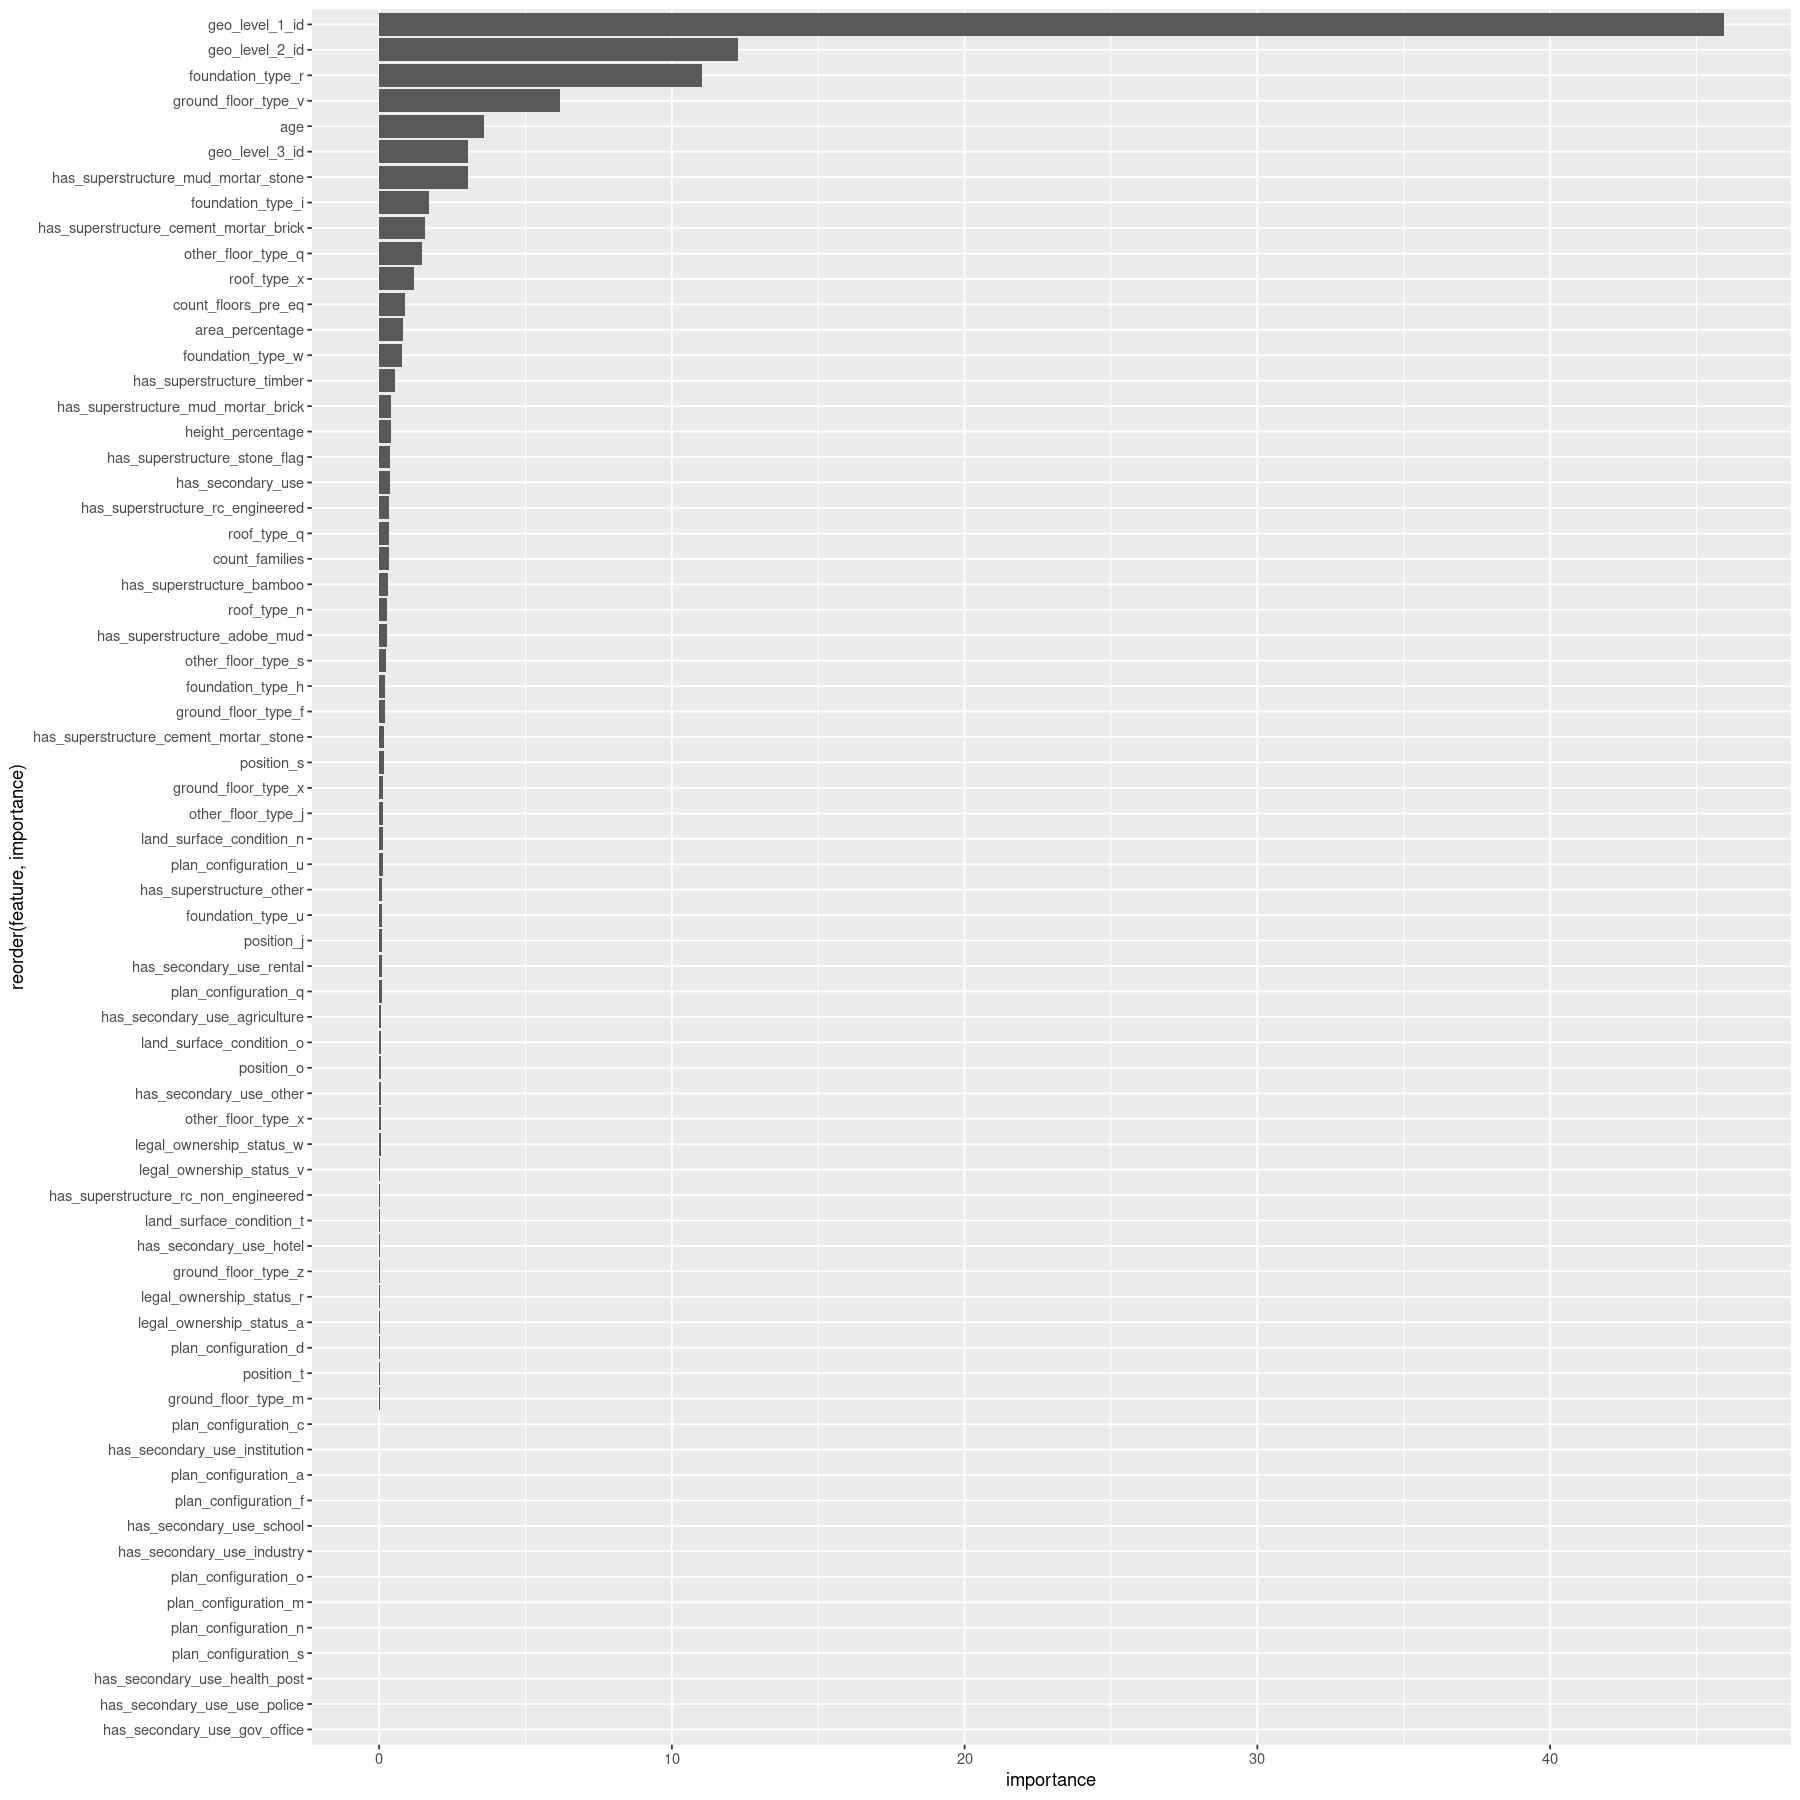

In [ ]:
# Convert the variable importance from 
# the model we built to a data frame 
varImpDT = summary(gbmModel, plot=FALSE)

# Change the column names of the data frame to "feature" and "importance"
colnames(varImpDT) = c("feature", "importance") # Call ggplot, specify x to be the importance and y to be a 
# re-ordering of the feature based on their respective importance. 
# We list importance on the x axis to avoid the feature names to overlap
ggplot(varImpDT, aes(x= importance, y=reorder(feature, importance))) + geom_bar(stat='identity')

# Task 4 : Predictions building

Now that we have trained all of our models with the full data set, we can build the output that we are going to submit to the competition. In this part we first process the test data, in orderto be able to get predictions from our models. We first generate dummies, add them to the original data frame, remove the building_id column, similarly as what's been done in Task 1.

In [29]:
# We must first apply the same feature engineering as in the beginning
# to ensure the data is formatted the same way than the data we used 
# to build our models.

# Generate a new dummies data frame
dataDumsTest = dummy(testValues, int=TRUE)

# Remove the categorical variables and merge the test 
# dataframe with the dummy variables
test = cbind(testValues[,-varsToRemove], dataDumsTest)

# We set the rownames of the dataPP data frame to be the 
# specified building_id, then we drop the building_id
# column from the data frame
rownames(test) = test$building_id
test = test[,-1]

**Decision tree model**

Using the code below we generated predictions for the decision tree model with minimal `cp` that we picked from the model selection step in Task 3. The cross validation F1-mean we had obtained was $0.726167764355289$, and we obtained a score of $0.7258$ for the submission, which is okay, and is really close to what we had observed during the 10-folds crossvalidation.

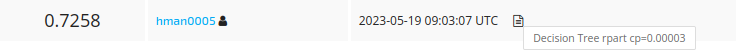

In [30]:
# Decision tree model (decisionTreeModel)
# We pick the model we trained in the
# model selection part of decision trees


# Predict the test data using the decisionTreeModel
# and find which class has the higher probability
predictions = predict(decisionTreeModel,test)
predictions = colnames(predictions)[apply(predictions,1,which.max)]     

# Prepare the submission dataframe
sub = data.frame(cbind(rownames(test), predictions))

# Formatting the columns as per the submission_format.csv file
colnames(sub) = c("building_id","damage_grade")

# Write our sub data frame in the file, don't put row names and
# remove the automatic quoting when writing in csv 
write.csv(sub, "predictions_decision_tree.csv", row.names=FALSE, quote=FALSE)

**Gradient boosting model**

Using the code below we generated predictions for the gradient boosting model with `n.trees=500, interaction.depth=3` that we picked from the model selection step in Task 3. The cross validation F1-mean we had obtained was $0.708642754885376$, and we obtained a score of $0.7089$ for the submission, which is really bad compared to the decision tree model. But is really close to what we had observed during the 5-folds crossvalidation.

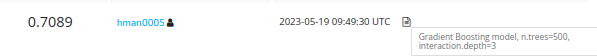

In [ ]:
# Gradient boosting model
# We pick the model with the number of trees and interaction
# depth we found in the model selection step, and train it
# with the whole training dataset

# Predict the test data using the gbmModel
# and find which class has the higher probability
predictions = predict(gbmModel,test)
predictions = colnames(predictions)[apply(predictions,1,which.max)]     

# Prepare the submission dataframe
sub = data.frame(cbind(rownames(test), predictions))

# Formatting the columns as per the submission_format.csv file
colnames(sub) = c("building_id","damage_grade")

# Write our sub data frame in the file, don't put row names and
# remove the automatic quoting when writing in csv 
write.csv(sub, "predictions_gradient_boosting_model.csv", row.names=FALSE, quote=FALSE)

Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 500 trees...




# Task 5 : Features relevancy ranking

The relevancy of each feature $\textbf{x}_i$ will be computed as:
$$Rel(\textbf{x}_i) = H(y|X^{-i}) - H(y|X)$$

Using that $H(\textbf{y}|\textbf{X}) = E_{\textbf{X}}[H(\textbf{y}|X)] \textit{(2.15.5.2)}$ and that $H(\textbf{y}|X=z) = -\displaystyle{\sum_{y} \mathbb{P}(\textbf{y}=y | X = z) \cdot \log_2(\mathbb{P}(\textbf{y}=y|X=z))}$, we get 
$\begin{equation}
\begin{split}
 H(\textbf{y}|\textbf{X}) &= E_{\textbf{X}}[H(\textbf{y}|X)] \\
& = -E_{\textbf{X}}[\displaystyle{\sum_{y \in \text{damage grade}}} \mathbb{P}(\textbf{y}=y|X=z)\cdot \log_2(\mathbb{P}(\textbf{y}=y|X=z)))] 
\end{split}
\end{equation}$ 

We compute the conditional entropy of the target $\textbf{y}$ given $X^{-i}$ in a very similar way, using this time a model trained with that feature excluded.

In [17]:
entropiesDiscardingI = function(data, i){

    # Find the index of the last column in
    # the data dataframe, supposed to be the
    # target variable
    columnToPredict = ncol(dataPP)

    # If i==0, we want to consider all of the 
    # features in the specified data dataframe
    # Otherwise, we build the model removing the
    # i-th column (i-th feature) of the dataframe
    if(i==0){
        modeli = rpart(damage_grade~., data=data, cp=cp)
        preds = predict(modeli, dataPP[,-columnToPredict])
    }else{
        modeli = rpart(damage_grade~., data=data[,-i], cp=cp)
        preds = predict(modeli, dataPP[,-c(i,columnToPredict)])
    }

    # Sometimes for some reasons the preds dataframe
    # gets returned as an array of dataframe with a 
    # third dimension of 1, so we transform that 3d array
    # into our dataframe by removing the third dimension
    dim(preds) = c(260601,3)

    # Because some of the conditional probabilities 
    # returned by the model have 0 values, and that 
    # log2 is undefined at 0, we must change these 
    # values to be as close as 0 possible, in order to
    # not get NaNs in the final return statement
    preds[preds[,1] == 0] = 0.000000000001 
    preds[preds[,2] == 0] = 0.000000000001
    preds[preds[,3] == 0] = 0.000000000001
    
    # That is the final equation line of the markdown block
    # specified above
    return(- mean( data.frame(preds[,1] * log2(preds[,1]) + preds[,2] * log2(preds[,2]) + preds[,3] * log2(preds[,3]))[,1] ))
}

We then need a function to compute the `relevancy` of each feature associated with its name in a dataframe. To do that we define the function below, which takes as only parameter a dataset. We compute the entropy in the fullModel, as well as the entropies of the models $X^{-i}$ without the $i$-th feature, and save them in the `entropies` vector. Once that is done, we can compute the `relev` vector and bind it to the vector contaning the column names of the dataset. 

The cell calling `relevancy` ran for around 3-4 hours in total.

In [18]:
relevancy = function(data){

    # Compute the entropy of the whole 
    # model, with every feature included
    entropyFullModel = entropiesDiscardingI(data,0)
    cat(paste0("Entropy of the model including all features (H(y|X)) = ", entropyFullModel, "\n"))

    # Define the vector of entropies, entropies
    # At each iteration of the loop, compute the
    # entropy with the left out i-th feature
    # and add that entropy to the entropies vector
    entropies = c()
    for(i in 1:ncol(data)-1){
        entropyWithoutFeatureI = entropiesDiscardingI(data,i)
        cat(paste0("Entropy of the model excluding feature ",i," (", colnames(data[,i]) ,") = ", entropyWithoutFeatureI, "\n"))
        entropies=c(entropies, entropyWithoutFeatureI)
    }

    # Compute the relev vector, which is the relevancy 
    # as defined in the first equation of the markdown of this part
    relev = entropies - rep(c(entropyFullModel), ncol())

    # Merge the relev vector with the respective feature names
    relevanciesDF = data.frame(cbind(colnames(data[,1:ncol(data)-1]), relev))
    relevanciesDF$relev = as.numeric(relevanciesDF$relev)

    return(relevanciesDF)
}

In [22]:
relevancies = relevancy(dataPP)

As per the graph below, the 5 most important feature based on the entropy computation for decision tree models are: `geo_level_1_id`, `geo_level_2_id`, `geo_level_3_id`, `has_superstructure_mud_mortar_stone` and `age`. When comparing with the feature importance for the decision tree we built in Task 2, which is calculated differently, we can see that some features are as important in their ranking in both assessments. That is the case for `geo_level_1_id` and `geo_level_2_id`. But some other features, although they don't have the same ranking, are still among the most important one in both, such as: `foundation_type_r`, `geo_level_3_id`, `height_percentage`, `has_superstructure_mud_mortar_stone`, `age`, `area_percentage`. But it seems (from a visual point of view), that the entropy-based feature importance assessment is more "discriminative" than the rpart one. That is, it seems that most of the total variable importance is shared between 5-10 features, when for rpart the variable importance was spread more widely over 20-30 features. 

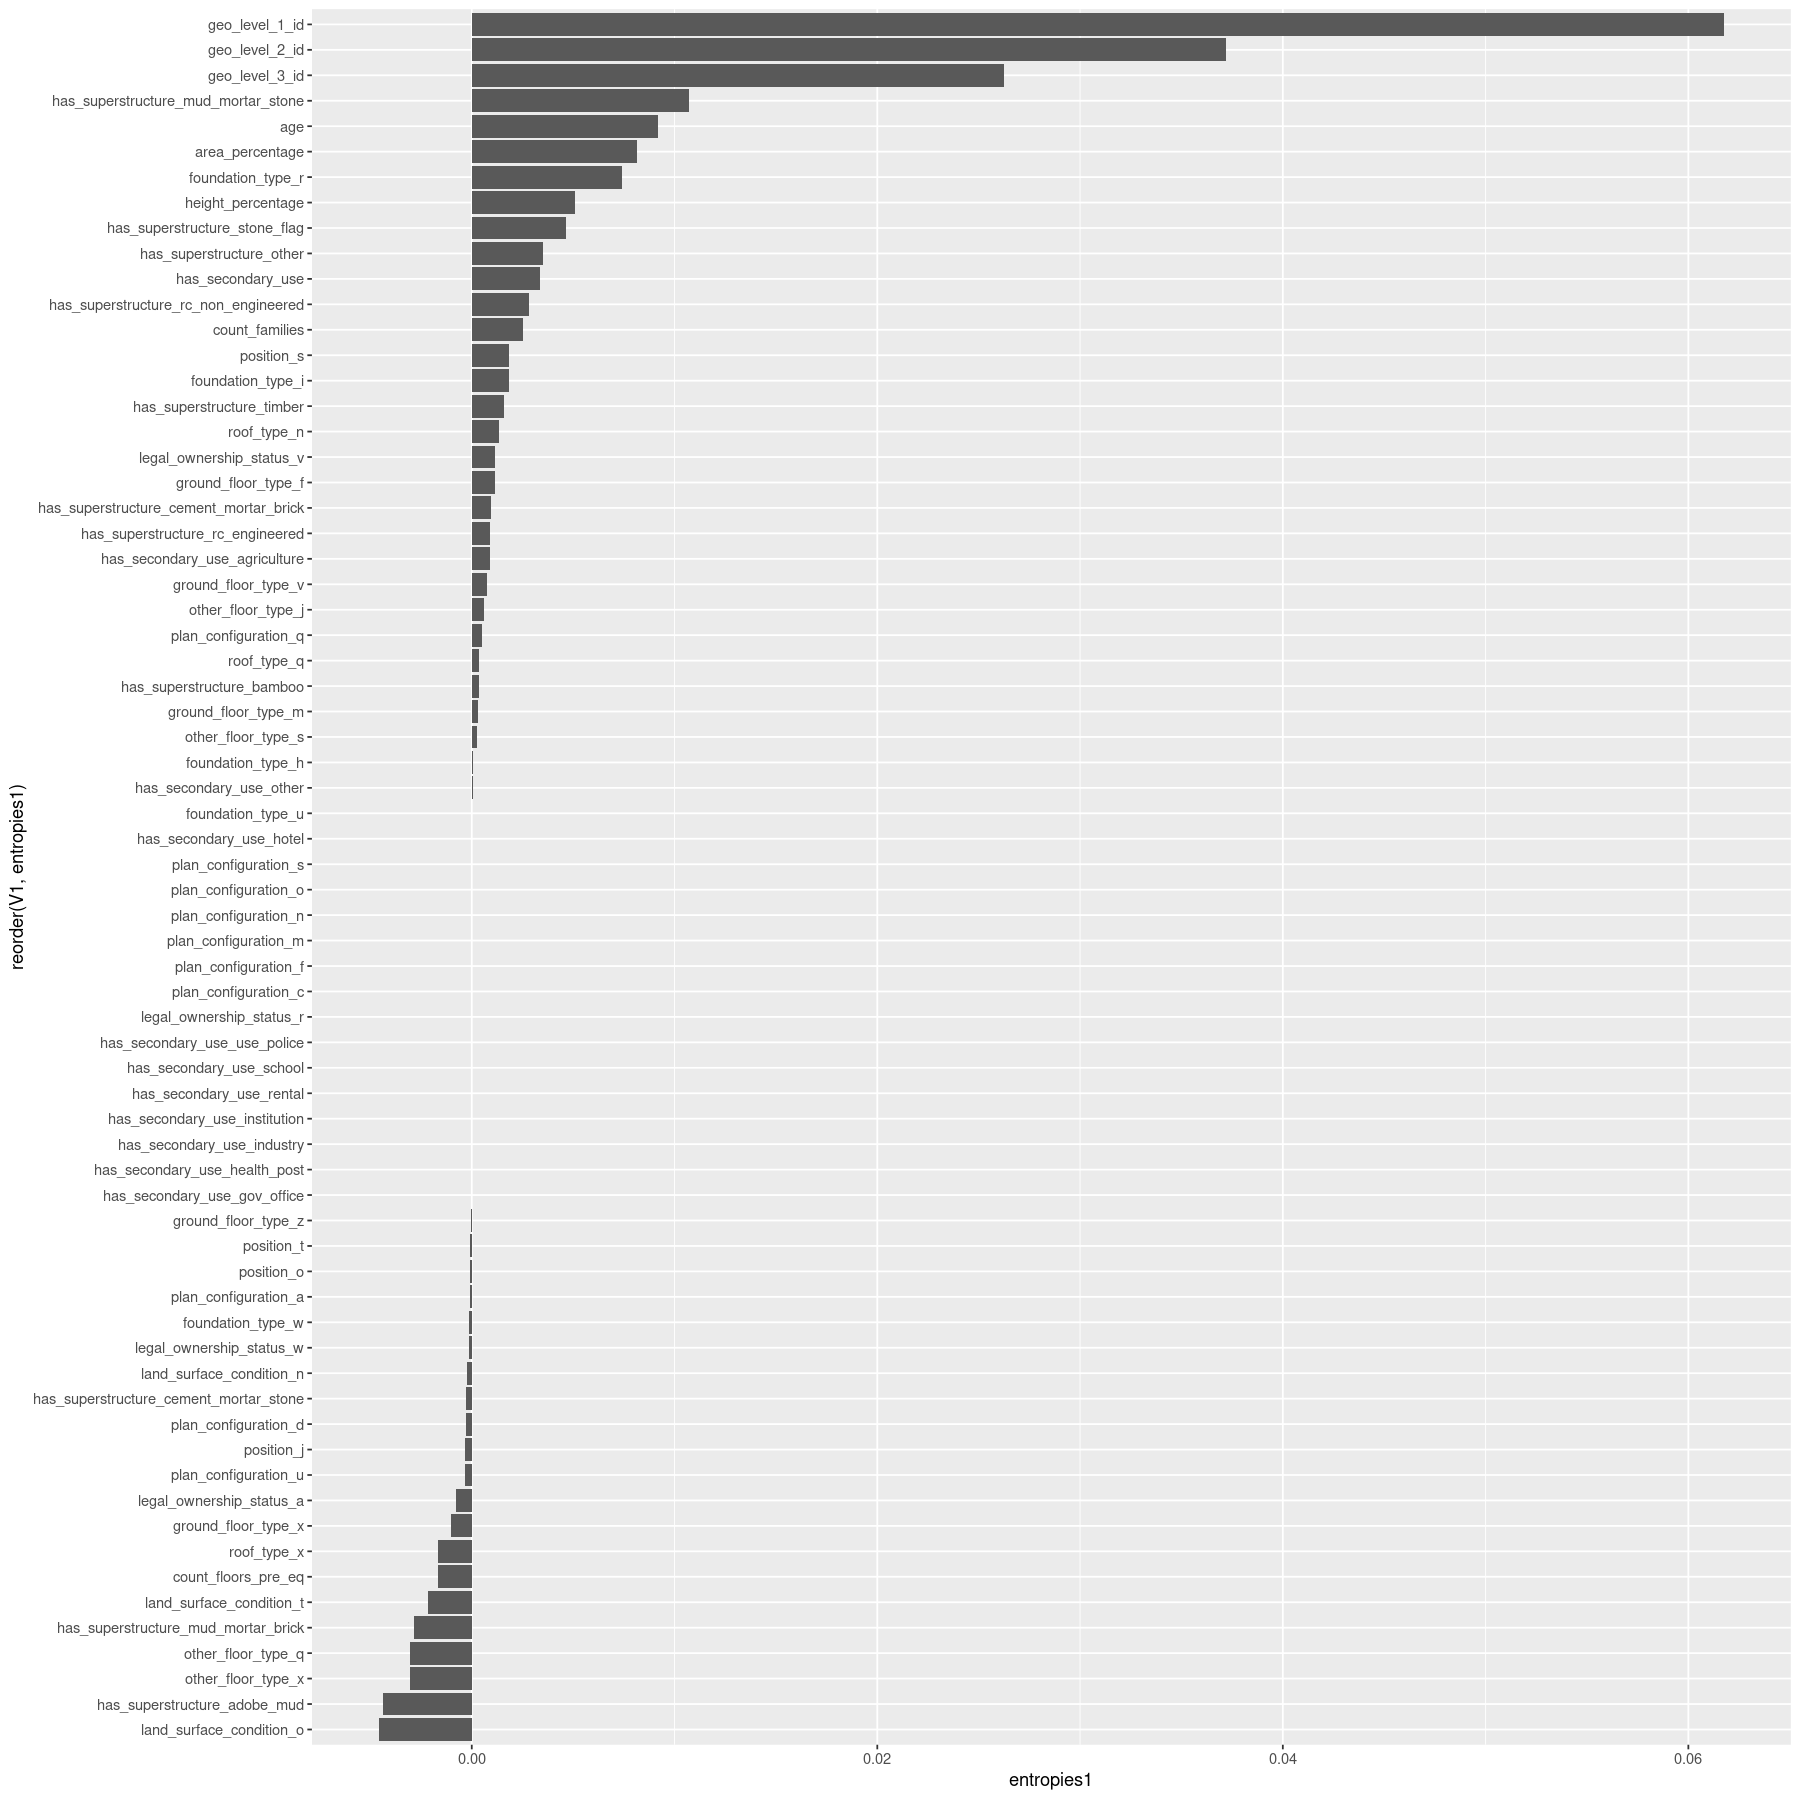

In [ ]:
# ggplot(relevancies, aes(x= relev, y=reorder(V1, relev))) + geom_bar(stat='identity')